In [1]:
!pip install -q "gymnasium[mujoco]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 13.9 MB/s eta 0:00:00


Derived from ADIN Lab's EPPO [implementation](https://github.com/adinlab/EPPO), as outlined in [this paper](https://arxiv.org/html/2503.01468v2). Replicates the experiments therein. Recorded data relates to the `HalfCheetah` environment, using the `front-one` strategy.



In [2]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import itertools
import time
import copy
from gymnasium.wrappers import RescaleAction
from typing import Optional
from torch.distributions import Normal
from tqdm import tqdm

# Shared Code

In [155]:
# @title Experiment Parameters
environment = "halfcheetah" # @param ["halfcheetah", "ant"]
strategy_halfcheetah = 'front_one' # @param ["back_one", "front_one", "cross_v1", "cross_v2"]
strategy_ant = 'back_one' # @param ["back_one", "front_one", "back_two", "front_two", "parallel", "cross"]

strategy = strategy_ant if environment=='ant' else strategy_halfcheetah

# common parameters
max_steps = 500_000
learning_rate = 3e-4
learn_frequency = 2047  # it is 2048 but we are using 0 based index
batch_size = 256
max_iter = 10
act_actor = "relu"
act_critic = "relu"
depth_actor = 3
depth_critic = 3
width_actor = 256
width_critic = 256
gamma = 0.99
no_norm_actor = False
no_norm_critic = False
eval_frequency = 20_000
eval_episodes = 10
buffer_size = 2048

# ppo related
clip_param = 0.2
gae_lambda = 0.95
max_grad_norm = 0.5

# eppo related
regularization_coeff = 0.01
radius = 0.01
seed = 1
exploration_types = ["mean", "cor", "ind"]
exploration_type = exploration_types[0]

exp_name = f"{environment}_{strategy}"
print(f"Experiment: {exp_name}")

device = "cuda" if torch.cuda.is_available() else "cpu"

Experiment: halfcheetah_front_one


In [156]:
# @title Env and wrappers
class ParalyzeActionWrapper(gym.ActionWrapper):
    def __init__(self, env, joint_idxs, paralyzed_ratio=0.0):
        super().__init__(env)
        self.paralyzed_ratio = paralyzed_ratio
        self.joint_idxs = joint_idxs
        self.coeff = np.ones(self.action_space.shape)
        self.coeff[joint_idxs] = paralyzed_ratio

    def step(self, action):
        action = action * self.coeff
        return self.env.step(action)

class SinglePrecision(gym.ObservationWrapper):

    def __init__(self, env):
        super().__init__(env)

        if isinstance(self.observation_space, gym.spaces.Box):
            obs_space = self.observation_space
            self.observation_space = gym.spaces.Box(obs_space.low, obs_space.high, obs_space.shape)
        elif isinstance(self.observation_space, gym.spaces.Dict):
            obs_spaces = copy.copy(self.observation_space.spaces)
            for k, v in obs_spaces.items():
                obs_spaces[k] = gym.spaces.Box(v.low, v.high, v.shape)
            self.observation_space = gym.spaces.Dict(obs_spaces)
        else:
            raise NotImplementedError

    def observation(self, observation: np.ndarray) -> np.ndarray:
        if isinstance(observation, np.ndarray):
            return observation.astype(np.float32)
        elif isinstance(observation, dict):
            observation = copy.copy(observation)
            for k, v in observation.items():
                observation[k] = v.astype(np.float32)
            return observation


def get_idx_to_paralyze(exp_name):
    if "ant" in exp_name:
        if "front_one" in exp_name:  # front left joints
            return [2, 3]
        elif "front_two" in exp_name:  # front left and right joints
            return [2, 3, 4, 5]
        elif "back_one" in exp_name:  # back left joints
            return [6, 7]
        elif "back_two" in exp_name:  # back left and right joints
            return [0, 1, 6, 7]
        elif "parallel" in exp_name:  # left front and back joints
            return [2, 3, 6, 7]
        elif "cross" in exp_name:  # left front and right back joints
            return [2, 3, 0, 1]
    elif "halfcheetah" in exp_name:
        if "front_one" in exp_name:
            return [5]
        elif "back_one" in exp_name:
            return [2]
        elif "cross_v1" in exp_name:
            return [2, 4]
        elif "cross_v2" in exp_name:
            return [1, 5]
    else:
        raise ValueError(f"Unknown experiment: {exp_name}")


def make_env(
    exp_name: str,
    seed: int,
    idxs: Optional[list] = None,
    paralyzed_ratio: Optional[float] = 0.0,
) -> gym.Env:

    if "ant" in exp_name:
        env_name = "Ant-v5"
    elif "halfcheetah" in exp_name:
        env_name = "HalfCheetah-v5"
    else:
        raise NotImplementedError(f"Environment {exp_name} not implemented")

    env = gym.make(env_name)
    env = RescaleAction(env, -1.0, 1.0)
    env = SinglePrecision(env)
    env = ParalyzeActionWrapper(env, idxs, paralyzed_ratio)

    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    return env

In [157]:
# @title Experiment Code
def totorch(x, dtype=torch.float32, device="cuda"):
    return torch.as_tensor(x, dtype=dtype, device=device)


def tonumpy(x):
    return x.data.cpu().numpy()


class ExperienceMemoryTorch:
    """Fixed-size buffer to store experience tuples."""

    field_names = ["state", "action", "reward", "next_state", "terminated", "step"]

    def __init__(self, device, buffer_size, dims):
        self.device = device
        self.buffer_size = buffer_size
        self.dims = dims
        self.reset()

    def reset(self, buffer_size=None):
        if buffer_size is not None:
            self.buffer_size = buffer_size
        self.data_size = 0
        self.pointer = 0
        self.memory = {
            field: torch.empty(self.dims[field], device=self.device)
            for field in self.field_names
        }

    def add(self, state, action, reward, next_state, terminated, step):
        for field, value in zip(
            self.field_names, [state, action, reward, next_state, terminated, step]
        ):
            self.memory[field][self.pointer] = value
        self.pointer = (self.pointer + 1) % self.buffer_size
        self.data_size = min(self.data_size + 1, self.buffer_size)

    def sample_by_index(self, index):
        return tuple(self.memory[field][index] for field in self.field_names)

    def sample_all(self):
        return self.sample_by_index(range(self.data_size))

    def __len__(self):
        return self.data_size

    @property
    def size(self):
        return self.data_size


class ParalysisExpriment(object):
    def __init__(
        self,
        agent,
        exp_name,
        seed,
        max_steps,
        eval_frequency,
        device,
        learn_frequency,
        eval_episodes,
        max_iter,
        gamma,
    ):
        self.exp_name = exp_name
        self.seed = seed
        self.max_steps = max_steps
        self.eval_frequency = eval_frequency
        self.device = device
        self.learn_frequency = learn_frequency
        self.eval_episodes = eval_episodes
        self.max_iter = max_iter
        self.gamma = gamma

        self.idx_to_paralyze = get_idx_to_paralyze(self.exp_name)
        self.prepare_tasks()

        self.agent = agent

        self.AULCS = []
        self.FINAL_RETURNS = []

    def prepare_tasks(self):
        task_order = [1.0, 0.75, 0.5, 0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
        self.n_tasks = len(task_order)

        self.tasks = {
            task_id: {"task": coeff, "idxs": self.idx_to_paralyze}
            for task_id, coeff in enumerate(task_order)
        }
        task_names = [task_info["task"] for task_info in self.tasks.values()]
        print(f"Tasks: {task_names}")

    def set_task(self, task_id, task_info):
        task = task_info["task"]

        self.env = make_env(
            exp_name=self.exp_name,
            seed=self.seed,
            idxs=task_info["idxs"],
            paralyzed_ratio=task,
        )

        self.eval_env = make_env(
            exp_name=self.exp_name,
            seed=self.seed + 100,
            idxs=task_info["idxs"],
            paralyzed_ratio=task,
        )

        return task

    def train(self):
        time_start = time.time()

        information_dict = {
            "episode_rewards": torch.zeros(self.max_steps * (self.n_tasks + 1)),
            "episode_steps": torch.zeros(self.max_steps * (self.n_tasks + 1)),
            "step_rewards": np.empty((2 * self.max_steps * self.n_tasks), dtype=object),
        }

        r_cum = np.zeros(1)
        episode = 0
        e_step = 0
        for task_id, task_info in self.tasks.items():
            # task starts
            task = self.set_task(task_id, task_info)
            print(f"Commencing task {task_id}: {task}")

            r_cum = np.zeros(1)
            s, _ = self.env.reset()
            s = totorch(s, device=self.device)
            for step in tqdm(
                range(task_id * self.max_steps, (task_id + 1) * self.max_steps),
                leave=True,
                disable=True,
            ):
                e_step += 1

                if step % self.eval_frequency == 0:
                    self.eval(step)

                a = self.agent.select_action(s).clip(-1.0, 1.0)

                sp, r, done, truncated, info = self.env.step(tonumpy(a))
                sp = totorch(sp, device=self.device)

                self.agent.store_transition(s, a, r, sp, done, truncated, step + 1)

                information_dict["step_rewards"][step] = (
                    episode,
                    step,
                    r,
                )

                s = sp  # Update state
                r_cum += r  # Update cumulative reward

                if (step % self.learn_frequency) == 0:
                    # print("Learning at step: ", step)
                    self.agent.learn(max_iter=self.max_iter)

                if done or truncated:

                    information_dict["episode_rewards"][episode] = r_cum.item()
                    information_dict["episode_steps"][episode] = step
                    if episode % 10 == 0:
                        print(
                            f"Episode: {episode + 1:4d}\tN-steps: {step:7d}\tReward: {r_cum.item():10.3f}"
                        )
                    s, _ = self.env.reset()
                    s = totorch(s, device=self.device)
                    r_cum = np.zeros(1)
                    episode += 1
                    e_step = 0

            # task finishes
            self.eval(step, final=True)
            self.agent.end_task()

        time_end = time.time()
        print(f"Training time: {time_end - time_start:.2f} seconds")

        print(f"AULC: {np.mean(self.AULCS)}")
        print(f"Final Return: {np.mean(self.FINAL_RETURNS)}")

    @torch.no_grad()
    def eval(self, n_step, final=False):
        self.agent.eval()
        results = torch.zeros(self.eval_episodes)
        collect_infos = {}
        for episode in range(self.eval_episodes):
            collect_infos[episode] = []
            s, info = self.eval_env.reset()
            s = totorch(s, device=self.device)
            step = 0
            a = self.agent.select_action(s, is_training=False)
            done = False

            while not done:
                a = self.agent.select_action(s, is_training=False)

                sp, r, term, trunc, info = self.eval_env.step(tonumpy(a))
                collect_infos[episode].append(info)

                done = term or trunc
                s = totorch(sp, device=self.device)
                results[episode] += r
                step += 1

        print(f"EVALUATION\tN-steps: {n_step:7d}\tMean_Reward: {results.mean():10.3f}")
        self.AULCS.append(results.mean())
        if final:
            self.FINAL_RETURNS.append(results.mean())

        self.agent.train()

In [158]:
# @title Network Arch
def get_activation(act):
    if act == "relu":
        return nn.ReLU
    elif act == "tanh":
        return nn.Tanh
    else:
        raise NotImplementedError(f"{act} is not implemented")


def create_net(d_in, d_out, depth, width, act="crelu", has_norm=True, n_elements=1):
    assert depth > 0, "Need at least one layer"

    act = get_activation(act)

    if depth == 1:
        arch = nn.Linear(d_in, d_out)
    elif depth == 2:
        arch = nn.Sequential(
            nn.Linear(d_in, width),
            (
                nn.LayerNorm(width, elementwise_affine=False)
                if has_norm
                else nn.Identity()
            ),
            act(),
            nn.Linear(width, d_out),
        )
    else:
        in_layer = nn.Linear(d_in, width)
        if n_elements > 1:
            out_layer = nn.Linear(width, d_out, n_elements)
        else:
            out_layer = nn.Linear(width, d_out)

        # This can probably be done in a more readable way, but it's fast and works...
        hidden = list(
            itertools.chain.from_iterable(
                [
                    [
                        (
                            nn.LayerNorm(width, elementwise_affine=False)
                            if has_norm
                            else nn.Identity()
                        ),
                        act(),
                        nn.Linear(width, width),
                    ]
                    for _ in range(depth - 1)
                ]
            )
        )[:-1]
        arch = nn.Sequential(in_layer, *hidden, out_layer)

    return arch


class GaussianHead(nn.Module):
    def __init__(self, n):
        super().__init__()
        self._n = n

    def forward(self, x, is_training=True, return_dist=False):
        mean = x[..., : self._n]
        logstd = x[..., self._n :].clamp(-10.0, -2.0)
        std = logstd.exp()
        dist = Normal(mean, std, validate_args=False)
        if is_training:
            y = dist.rsample()
            y_logprob = dist.log_prob(y).sum(dim=-1, keepdim=True)
        else:
            y = dist.mode
            y_logprob = None
        if return_dist:
            return y, y_logprob, dist
        return y, mean


class ActorNetProbabilistic(nn.Module):
    def __init__(self, dim_obs, dim_act, depth=3, width=256, act="relu", has_norm=True):
        super().__init__()
        self.dim_act = dim_act
        self.arch = create_net(dim_obs, 2 * dim_act, depth, width, act, has_norm)

        self.head = GaussianHead(self.dim_act)

    def forward(self, x, is_training=True, return_dist=False):
        f = self.arch(x)
        return self.head(f, is_training, return_dist=return_dist)


class EvidentialCriticNet(nn.Module):
    def __init__(self, dim_obs, depth=3, width=256, act="relu", has_norm=False):
        super().__init__()

        self.arch = create_net(dim_obs, 4, depth, width, act=act, has_norm=has_norm)

    @staticmethod
    def evidence(x):
        return torch.exp(x)

    def forward(self, x):
        output = self.arch(x)
        gamma, logv, log_alpha, log_beta = output.chunk(4, dim=-1)
        v = self.evidence(logv)
        alpha = self.evidence(log_alpha) + 1  # to ensure that alpha > 1
        beta = self.evidence(log_beta)
        return gamma, v, alpha, beta

In [159]:
# @title Evidential PPO Algorithm
class EPPOActor(nn.Module):
    '''
      Looks like a normal PPO actor.
    '''
    def __init__(
        self,
        arch,
        n_state,
        n_action,
        clip_param,
        max_grad_norm,
        learning_rate,
        depth_actor,
        width_actor,
        act_actor,
        no_norm_actor,
        device,
    ):
        super().__init__()
        self.n_state = n_state
        self.n_action = n_action
        self.arch = arch
        self.clip = clip_param
        self.max_grad_norm = max_grad_norm
        self.learning_rate = learning_rate
        self.depth_actor = depth_actor
        self.width_actor = width_actor
        self.act_actor = act_actor
        self.no_norm_actor = no_norm_actor
        self.device = device

        self.initialize()

    def initialize(self):
        self.model = self.arch(
            self.n_state,
            self.n_action,
            depth=self.depth_actor,
            width=self.width_actor,
            act=self.act_actor,
            has_norm=not self.no_norm_actor,
        ).to(self.device)
        self.optim = torch.optim.Adam(self.model.parameters(), self.learning_rate)

    def evaluate(self, s):
        _, _, dist = self.model(s, return_dist=True)
        # return dist here
        return dist

    def loss(self, s, a, old_probs, adv):
        dist = self.evaluate(s)
        new_probs = dist.log_prob(a)
        foo = new_probs.sum(1, keepdim=True) - old_probs.sum(1, keepdim=True)
        prob_ratio = torch.exp(foo.clamp(-20, 1))

        weighted_probs = adv * prob_ratio
        weighted_clipped_probs = (
            torch.clamp(prob_ratio, 1 - self.clip, 1 + self.clip) * adv
        )

        actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()
        self.clip_fraction = ( # No idea what this is for. Looks unused.
            (torch.abs((prob_ratio - 1)) > self.clip).to(torch.float).mean()
        )

        return actor_loss

    def update(self, s, a, old_probs, adv):
        self.optim.zero_grad()
        loss = self.loss(s, a, old_probs, adv)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optim.step()

    def act(self, s, is_training=True):
        a, e = self.model(s, is_training=is_training)
        return a, e


class EvidentialCritic(nn.Module):
    def __init__(
        self,
        arch,
        n_state,
        max_grad_norm,
        depth_critic,
        width_critic,
        act_critic,
        no_norm_critic,
        device,
        learning_rate,
        regularization_coeff,
    ):
        super().__init__()

        self.arch = arch
        self.max_grad_norm = max_grad_norm
        self.depth_critic = depth_critic
        self.width_critic = width_critic
        self.act_critic = act_critic
        self.no_norm_critic = no_norm_critic
        self.n_state = n_state
        self.learning_rate = learning_rate
        self.iter = 0
        self.device = device
        self.initialize()

        self.regularization_coeff = regularization_coeff

    def initialize(self):
        self.model = self.arch(
            self.n_state,
            depth=self.depth_critic,
            width=self.width_critic,
            act=self.act_critic,
            has_norm=not self.no_norm_critic,
        ).to(self.device)
        self.loss = torch.nn.MSELoss()
        self.optim = torch.optim.Adam(self.model.parameters(), self.learning_rate)

        self.prior_gamma = torch.distributions.Normal(
            torch.tensor(0.0).to(self.device), torch.tensor(100.0).to(self.device)
        )
        self.prior_v = torch.distributions.Gamma(
            torch.tensor(5.0).to(self.device), torch.tensor(1.0).to(self.device)
        )
        self.prior_alpha = torch.distributions.TransformedDistribution(
            torch.distributions.Gamma(
                torch.tensor(5.0).to(self.device), torch.tensor(1.0).to(self.device)
            ),
            [
                torch.distributions.transforms.AffineTransform(
                    loc=1.0, scale=1.0, cache_size=1
                )
            ],
        )
        self.prior_beta = torch.distributions.Gamma(
            torch.tensor(5.0).to(self.device), torch.tensor(1.0).to(self.device)
        )

    def get_prior(self, x):
        gamma, v, alpha, beta = self.model(x)
        return gamma, v, alpha, beta

    def loss(self, state, target):
        gamma, v, alpha, beta = self.get_prior(state)
        twoBlambda = 2 * beta * (1 + v)
        loss = (
            -0.5 * torch.log(v)
            - alpha * torch.log(twoBlambda)
            + (alpha + 0.5) * torch.log(v * (target - gamma) ** 2 + twoBlambda)
            + torch.lgamma(alpha)
            - torch.lgamma(alpha + 0.5)
        )

        regularization = (
            self.prior_gamma.log_prob(gamma).mean()
            + self.prior_v.log_prob(v).mean()
            + self.prior_alpha.log_prob(alpha).mean()
            + self.prior_beta.log_prob(beta).mean()
        )
        loss -= regularization * self.regularization_coeff

        return loss.mean()

    def update(self, state, target):  # y denotes bellman target
        self.optim.zero_grad()
        loss = self.loss(state, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optim.step()

    def forward(self, x, target=False):
        gamma, v, alpha, beta = self.get_prior(x)
        if target:
            return gamma

        return gamma

    def get_mean_and_variance_of_y(self, x):
        gamma, v, alpha, beta = self.get_prior(x)
        mean = gamma
        variance = (beta / (alpha - 1)) * (1 + 1.0 / v)
        return mean, variance


class EvidentialProximalPolicyOptimization(nn.Module):
    _agent_name = "EPPO"

    def __init__(
        self,
        env,
        actor_nn,
        critic_nn,
        device,
        gamma,
        buffer_size,
        clip_param,
        gae_lambda,
        max_grad_norm,
        learning_rate,
        depth_actor,
        width_actor,
        act_actor,
        no_norm_actor,
        depth_critic,
        width_critic,
        act_critic,
        no_norm_critic,
        regularization_coeff,
        radius,
        exploration_type,
        batch_size,
    ):
        super().__init__()

        self.device = device
        self.env = env
        self.eps = 1e-6  # small value to avoid division by zero
        self.clip_param = clip_param
        self.gae_lambda = gae_lambda
        self.max_grad_norm = max_grad_norm
        self.learning_rate = learning_rate
        self.depth_actor = depth_actor
        self.width_actor = width_actor
        self.act_actor = act_actor
        self.no_norm_actor = no_norm_actor
        self.depth_critic = depth_critic
        self.width_critic = width_critic
        self.act_critic = act_critic
        self.no_norm_critic = no_norm_critic
        self.regularization_coeff = regularization_coeff
        self.radius = radius
        self.exploration_type = (exploration_type,)
        self.batch_size = batch_size

        self.dim_obs, self.dim_act = (
            self.env.observation_space.shape,
            self.env.action_space.shape,
        )
        self.dim_obs_flat, self.dim_act_flat = np.prod(self.dim_obs), np.prod(
            self.dim_act
        )
        self._u_min = totorch(self.env.action_space.low, device=self.device)
        self._u_max = totorch(self.env.action_space.high, device=self.device)
        self._x_min = totorch(self.env.observation_space.low, device=self.device)
        self._x_max = totorch(self.env.observation_space.high, device=self.device)

        self._gamma = gamma
        self.buffer_size = buffer_size

        dims = {
            "state": (self.buffer_size, self.dim_obs_flat),
            "action": (self.buffer_size, self.dim_act_flat),
            "next_state": (self.buffer_size, self.dim_obs_flat),
            "reward": (self.buffer_size),
            "terminated": (self.buffer_size),
            "step": (self.buffer_size),
        }

        self.experience_memory = ExperienceMemoryTorch(
            self.device, self.buffer_size, dims
        )

        self.actor = EPPOActor(
            actor_nn,
            self.dim_obs_flat,
            self.dim_act_flat,
            self.clip_param,
            self.max_grad_norm,
            self.learning_rate,
            self.depth_actor,
            self.width_actor,
            self.act_actor,
            self.no_norm_actor,
            self.device,
        )

        self.critic = EvidentialCritic(
            critic_nn,
            self.dim_obs_flat,
            self.max_grad_norm,
            self.depth_critic,
            self.width_critic,
            self.act_critic,
            self.no_norm_critic,
            self.device,
            self.learning_rate,
            self.regularization_coeff,
        )

        self._variance_coeff = (1.0 - self.gae_lambda) / (1.0 + self.gae_lambda)
        self._next_variance_coeff = ((1.0 - self.gae_lambda) / (self.gae_lambda)) ** 2
        self._accumulation_coeff = (self._gamma * self.gae_lambda) ** 2

        if exploration_type == "mean":
            self.calculate_advantages = self.calculate_advantages_mean
        elif exploration_type == "cor":
            # Could replace this with ind and setting variance_coeff to 1
            self.calculate_advantages = self.calculate_advantages_cor
        elif exploration_type == "ind":
            self.calculate_advantages = self.calculate_advantages_ind
        else:
            raise ValueError(f"Unknown exploration type: {exploration_type}")

    def end_task(self):
        self.experience_memory.reset()

    @torch.no_grad()
    def calculate_advantages_mean(self, states, next_states, rewards, dones):
        # EPPO_mean
        values = self.critic(states)
        next_values = self.critic(next_states)
        deltas = rewards + self._gamma * next_values * (1 - dones) - values
        advantages = torch.zeros_like(rewards)
        advantage = 0
        for i in reversed(range(len(deltas))):
            advantage = (
                self._gamma * self.gae_lambda * advantage * (1 - dones[i]) + deltas[i]
            )
            advantages[i] = advantage

        returns = advantages + values
        advantages = (advantages - advantages.mean()) / (advantages.std() + self.eps)
        return advantages, returns

    @torch.no_grad()
    def calculate_advantages_cor(self, states, next_states, rewards, dones):
        # EPPO_cor
        mean_values, variance_values = self.critic.get_mean_and_variance_of_y(states)
        mean_next_values, variance_next_values = self.critic.get_mean_and_variance_of_y(
            next_states
        )
        mean_deltas = (
            rewards + self._gamma * mean_next_values * (1 - dones) - mean_values
        )

        mean_advantages = torch.zeros_like(rewards)
        variance_advantages = torch.zeros_like(rewards)
        mean_advantage = 0
        variance_accumulated = 0
        for i in reversed(range(len(mean_deltas))):
            mean_advantage = (
                self._gamma * self.gae_lambda * mean_advantage * (1 - dones[i])
                + mean_deltas[i]
            )
            mean_advantages[i] = mean_advantage
            variance_accumulated = self._accumulation_coeff * (
                variance_accumulated * (1 - dones[i]) + variance_next_values[i]
            )
            variance_advantages[i] = (
                # Equivalent to ind, except for no variance coefficient
                variance_values[i] + self._next_variance_coeff * variance_accumulated
            )

        std_advantages = torch.sqrt(variance_advantages)
        advantages = mean_advantages + self.radius * std_advantages
        returns = mean_advantages + mean_values
        advantages = (advantages - advantages.mean()) / (advantages.std() + self.eps)
        return advantages, returns

    @torch.no_grad()
    def calculate_advantages_ind(self, states, next_states, rewards, dones):
        # EPPO_ind
        mean_values, variance_values = self.critic.get_mean_and_variance_of_y(states)
        mean_next_values, variance_next_values = self.critic.get_mean_and_variance_of_y(
            next_states
        )
        mean_deltas = (
            rewards + self._gamma * mean_next_values * (1 - dones) - mean_values
        )

        mean_advantages = torch.zeros_like(rewards)
        variance_advantages = torch.zeros_like(rewards)
        mean_advantage = 0
        variance_accumulated = 0
        for i in reversed(range(len(mean_deltas))):
            mean_advantage = (
                self._gamma * self.gae_lambda * mean_advantage * (1 - dones[i])
                + mean_deltas[i]
            )
            mean_advantages[i] = mean_advantage
            variance_accumulated = self._accumulation_coeff * (
                variance_accumulated * (1 - dones[i]) + variance_next_values[i]
            )
            variance_advantages[i] = (
                self._variance_coeff * variance_values[i]
                + self._next_variance_coeff * variance_accumulated
            )

        std_advantages = torch.sqrt(variance_advantages)
        advantages = mean_advantages + self.radius * std_advantages
        returns = mean_advantages + mean_values
        advantages = (advantages - advantages.mean()) / (advantages.std() + self.eps)
        return advantages, returns

    @torch.no_grad()
    def calculate_old_probs(self, states, actions):
        dist = self.actor.evaluate(states)
        return dist.log_prob(actions)

    def learn(self, max_iter=1):
        if self.batch_size > len(self.experience_memory):
            return None

        states, actions, rewards, next_states, terminateds, _ = (
            self.experience_memory.sample_all()
        )
        rewards = rewards.reshape(-1, 1)
        terminateds = terminateds.reshape(-1, 1)
        advantages, returns = self.calculate_advantages(
            states, next_states, rewards, terminateds
        )
        old_probs = self.calculate_old_probs(states, actions)

        for ii in range(max_iter):
            # shuffle data
            indices = torch.randperm(len(states))
            for i in range(0, len(states), self.batch_size):
                batch_indices = indices[i : i + self.batch_size]
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_probs = old_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]

                self.actor.update(
                    batch_states, batch_actions, batch_old_probs, batch_advantages
                )
                self.critic.update(batch_states, batch_returns)

        # clear memory after learning due to on-policy
        self.experience_memory.reset()

    @torch.no_grad()
    def select_action(self, s, is_training=True):
        a, _ = self.actor.act(s, is_training=is_training)
        return a.clamp(self._u_min + self.eps, self._u_max - self.eps)

    def Q_value(self, s, a):
        return self.critic(s)

    def store_transition(self, s, a, r, sp, terminated, truncated, step):
        self.experience_memory.add(s, a, r, sp, terminated or truncated, step)

# Run a trial with Evidential PPO

In [160]:
# @title Run Experiment
# env
eval_env = make_env(
    exp_name=exp_name,
    seed=seed + 100,
    idxs=get_idx_to_paralyze(exp_name),
    paralyzed_ratio=0.0,
)

# EPPO
agent = EvidentialProximalPolicyOptimization(
    env=eval_env,
    actor_nn=ActorNetProbabilistic,
    critic_nn=EvidentialCriticNet,
    device=device,
    gamma=gamma,
    buffer_size=buffer_size,
    clip_param=clip_param,
    gae_lambda=gae_lambda,
    max_grad_norm=max_grad_norm,
    learning_rate=learning_rate,
    depth_actor=depth_actor,
    width_actor=width_actor,
    act_actor=act_actor,
    no_norm_actor=no_norm_actor,
    depth_critic=depth_critic,
    width_critic=width_critic,
    act_critic=act_critic,
    no_norm_critic=no_norm_critic,
    regularization_coeff=regularization_coeff,
    radius=radius,
    exploration_type=exploration_type,
    batch_size=batch_size,
)

# experimenter
experimenter = ParalysisExpriment(
    agent=agent,
    exp_name=exp_name,
    seed=seed,
    max_steps=max_steps,
    eval_frequency=eval_frequency,
    device=device,
    learn_frequency=learn_frequency,
    eval_episodes=eval_episodes,
    max_iter=max_iter,
    gamma=gamma,
)

experimenter.train()

Tasks: [1.0, 0.75, 0.5, 0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
Commencing task 0: 1.0
EVALUATION	N-steps:       0	Mean_Reward:    187.372
Episode:    1	N-steps:     999	Reward:     54.970
Episode:   11	N-steps:   10999	Reward:    406.393
EVALUATION	N-steps:   20000	Mean_Reward:    596.693
Episode:   21	N-steps:   20999	Reward:    441.888
Episode:   31	N-steps:   30999	Reward:    541.480
EVALUATION	N-steps:   40000	Mean_Reward:    875.716
Episode:   41	N-steps:   40999	Reward:    675.509
Episode:   51	N-steps:   50999	Reward:    812.666
EVALUATION	N-steps:   60000	Mean_Reward:   1151.444
Episode:   61	N-steps:   60999	Reward:    903.672
Episode:   71	N-steps:   70999	Reward:   1051.080
EVALUATION	N-steps:   80000	Mean_Reward:   1405.171
Episode:   81	N-steps:   80999	Reward:   1231.307
Episode:   91	N-steps:   90999	Reward:   1395.843
EVALUATION	N-steps:  100000	Mean_Reward:   1655.552
Episode:  101	N-steps:  100999	Reward:   1392.734
Episode:  111	N-steps:  110999	Reward:   1461.651
EVALUATI

# Run a trial with Vanilla PPO

In [161]:
# @title Non-Evidential Critic
class CriticNet(nn.Module):
    def __init__(self, dim_obs, depth=3, width=256, act="relu", has_norm=False):
        super().__init__()
        # 1 output instead of 4
        self.arch = create_net(dim_obs, 1, depth, width, act=act, has_norm=has_norm)

    def forward(self, x):
        output = self.arch(x)
        return output

class NonEvidentialCritic(nn.Module):
    def __init__(
        self,
        arch,
        n_state,
        max_grad_norm,
        depth_critic,
        width_critic,
        act_critic,
        no_norm_critic,
        device,
        learning_rate,
        regularization_coeff,
    ):
        super().__init__()

        self.arch = arch
        self.max_grad_norm = max_grad_norm
        self.depth_critic = depth_critic
        self.width_critic = width_critic
        self.act_critic = act_critic
        self.no_norm_critic = no_norm_critic
        self.n_state = n_state
        self.learning_rate = learning_rate
        self.iter = 0
        self.device = device
        self.initialize()

        # No idea whether this is still of value. Basically, keep value estimates pegged to around this range.
        self.regularization_coeff = regularization_coeff
        self.prior_gamma = torch.distributions.Normal(
            torch.tensor(0.0).to(self.device), torch.tensor(100.0).to(self.device)
        )

    def initialize(self):
        self.model = self.arch(
            self.n_state,
            depth=self.depth_critic,
            width=self.width_critic,
            act=self.act_critic,
            has_norm=not self.no_norm_critic,
        ).to(self.device)
        self.loss = torch.nn.MSELoss()
        self.optim = torch.optim.Adam(self.model.parameters(), self.learning_rate)


    def loss(self, state, target):
        v_pred = self(state)
        loss = (target - v_pred) ** 2

        regularization = (
            self.prior_gamma.log_prob(v_pred).mean()
        )
        loss -= regularization * self.regularization_coeff

        return loss.mean()

    def update(self, state, target): # Just runs optimization based on above
        self.optim.zero_grad()
        loss = self.loss(state, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optim.step()

    def forward(self, x):
        return self.model(x)

In [162]:
# @title Non-Evidential PPO Algorithm
class ProximalPolicyOptimization(nn.Module):
    _agent_name = "PPO"

    def __init__(
        self,
        env,
        actor_nn,
        critic_nn,
        device,
        gamma,
        buffer_size,
        clip_param,
        gae_lambda,
        max_grad_norm,
        learning_rate,
        depth_actor,
        width_actor,
        act_actor,
        no_norm_actor,
        depth_critic,
        width_critic,
        act_critic,
        no_norm_critic,
        regularization_coeff,
        batch_size,
    ):
        super().__init__()

        self.device = device
        self.env = env
        self.eps = 1e-6  # small value to avoid division by zero
        self.clip_param = clip_param
        self.gae_lambda = gae_lambda
        self.max_grad_norm = max_grad_norm
        self.learning_rate = learning_rate
        self.depth_actor = depth_actor
        self.width_actor = width_actor
        self.act_actor = act_actor
        self.no_norm_actor = no_norm_actor
        self.depth_critic = depth_critic
        self.width_critic = width_critic
        self.act_critic = act_critic
        self.no_norm_critic = no_norm_critic
        self.regularization_coeff = regularization_coeff
        self.batch_size = batch_size

        self.dim_obs, self.dim_act = (
            self.env.observation_space.shape,
            self.env.action_space.shape,
        )
        self.dim_obs_flat, self.dim_act_flat = np.prod(self.dim_obs), np.prod(
            self.dim_act
        )
        self._u_min = totorch(self.env.action_space.low, device=self.device)
        self._u_max = totorch(self.env.action_space.high, device=self.device)
        self._x_min = totorch(self.env.observation_space.low, device=self.device)
        self._x_max = totorch(self.env.observation_space.high, device=self.device)

        self._gamma = gamma
        self.buffer_size = buffer_size

        dims = {
            "state": (self.buffer_size, self.dim_obs_flat),
            "action": (self.buffer_size, self.dim_act_flat),
            "next_state": (self.buffer_size, self.dim_obs_flat),
            "reward": (self.buffer_size),
            "terminated": (self.buffer_size),
            "step": (self.buffer_size),
        }

        self.experience_memory = ExperienceMemoryTorch(
            self.device, self.buffer_size, dims
        )

        self.actor = EPPOActor(
            actor_nn,
            self.dim_obs_flat,
            self.dim_act_flat,
            self.clip_param,
            self.max_grad_norm,
            self.learning_rate,
            self.depth_actor,
            self.width_actor,
            self.act_actor,
            self.no_norm_actor,
            self.device,
        )

        self.critic = NonEvidentialCritic(
            critic_nn,
            self.dim_obs_flat,
            self.max_grad_norm,
            self.depth_critic,
            self.width_critic,
            self.act_critic,
            self.no_norm_critic,
            self.device,
            self.learning_rate,
            self.regularization_coeff,
        )

    @torch.no_grad()
    def calculate_advantages(self, states, next_states, rewards, dones):
        values = self.critic(states)
        next_values = self.critic(next_states)
        deltas = rewards + self._gamma * next_values * (1 - dones) - values
        advantages = torch.zeros_like(rewards)
        advantage = 0
        for i in reversed(range(len(deltas))):
            advantage = (
                self._gamma * self.gae_lambda * advantage * (1 - dones[i]) + deltas[i]
            )
            advantages[i] = advantage

        returns = advantages + values
        advantages = (advantages - advantages.mean()) / (advantages.std() + self.eps)
        return advantages, returns

    @torch.no_grad()
    def calculate_old_probs(self, states, actions):
        dist = self.actor.evaluate(states)
        return dist.log_prob(actions)

    def end_task(self): # Called in experiment loop when a task finishes
        self.experience_memory.reset()

    def learn(self, max_iter=1):
        if self.batch_size > len(self.experience_memory):
            return None

        states, actions, rewards, next_states, terminateds, _ = (
            self.experience_memory.sample_all()
        )
        rewards = rewards.reshape(-1, 1)
        terminateds = terminateds.reshape(-1, 1)
        advantages, returns = self.calculate_advantages(
            states, next_states, rewards, terminateds
        )
        old_probs = self.calculate_old_probs(states, actions)

        for ii in range(max_iter):
            # shuffle data
            indices = torch.randperm(len(states))
            for i in range(0, len(states), self.batch_size):
                batch_indices = indices[i : i + self.batch_size]
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_probs = old_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]

                self.actor.update( # PPO Actor loss
                    batch_states, batch_actions, batch_old_probs, batch_advantages
                )
                # PPO Critic loss
                self.critic.update(batch_states, batch_returns)

        # clear memory after learning due to on-policy
        self.experience_memory.reset()

    @torch.no_grad()
    def select_action(self, s, is_training=True):
        a, _ = self.actor.act(s, is_training=is_training)
        return a.clamp(self._u_min + self.eps, self._u_max - self.eps)

    def store_transition(self, s, a, r, sp, terminated, truncated, step):
        self.experience_memory.add(s, a, r, sp, terminated or truncated, step)

In [163]:
# @title Run Control
# env
eval_env = make_env(
    exp_name=exp_name,
    seed=seed + 100,
    idxs=get_idx_to_paralyze(exp_name),
    paralyzed_ratio=0.0,
)

# PPO
agent = ProximalPolicyOptimization(
    env=eval_env,
    actor_nn=ActorNetProbabilistic,
    critic_nn=CriticNet,
    device=device,
    gamma=gamma,
    buffer_size=buffer_size,
    clip_param=clip_param,
    gae_lambda=gae_lambda,
    max_grad_norm=max_grad_norm,
    learning_rate=learning_rate,
    depth_actor=depth_actor,
    width_actor=width_actor,
    act_actor=act_actor,
    no_norm_actor=no_norm_actor,
    depth_critic=depth_critic,
    width_critic=width_critic,
    act_critic=act_critic,
    no_norm_critic=no_norm_critic,
    regularization_coeff=regularization_coeff,
    batch_size=batch_size,
)

# experimenter
experimenter = ParalysisExpriment(
    agent=agent,
    exp_name=exp_name,
    seed=seed,
    max_steps=max_steps,
    eval_frequency=eval_frequency,
    device=device,
    learn_frequency=learn_frequency,
    eval_episodes=eval_episodes,
    max_iter=max_iter,
    gamma=gamma,
)

experimenter.train()

Tasks: [1.0, 0.75, 0.5, 0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
Commencing task 0: 1.0
EVALUATION	N-steps:       0	Mean_Reward:    187.372
Episode:    1	N-steps:     999	Reward:     54.970
Episode:   11	N-steps:   10999	Reward:    378.171
EVALUATION	N-steps:   20000	Mean_Reward:    609.787
Episode:   21	N-steps:   20999	Reward:    491.111
Episode:   31	N-steps:   30999	Reward:    607.481
EVALUATION	N-steps:   40000	Mean_Reward:    788.074
Episode:   41	N-steps:   40999	Reward:    636.289
Episode:   51	N-steps:   50999	Reward:    683.336
EVALUATION	N-steps:   60000	Mean_Reward:    862.071
Episode:   61	N-steps:   60999	Reward:    733.510
Episode:   71	N-steps:   70999	Reward:    907.471
EVALUATION	N-steps:   80000	Mean_Reward:   1323.700
Episode:   81	N-steps:   80999	Reward:   1030.951
Episode:   91	N-steps:   90999	Reward:   1232.713
EVALUATION	N-steps:  100000	Mean_Reward:   1687.299
Episode:  101	N-steps:  100999	Reward:   1361.458
Episode:  111	N-steps:  110999	Reward:   1463.807
EVALUATI

# Display results

In [168]:
# @title result_output_experiment
result_output_experiment = "Tasks: [1.0, 0.75, 0.5, 0.25, 0.0, 0.25, 0.5, 0.75, 1.0] Commencing task 0: 1.0 EVALUATION\tN-steps:       0\tMean_Reward:    187.372 Episode:    1\tN-steps:     999\tReward:     54.970 Episode:   11\tN-steps:   10999\tReward:    406.393 EVALUATION\tN-steps:   20000\tMean_Reward:    596.693 Episode:   21\tN-steps:   20999\tReward:    441.888 Episode:   31\tN-steps:   30999\tReward:    541.480 EVALUATION\tN-steps:   40000\tMean_Reward:    875.716 Episode:   41\tN-steps:   40999\tReward:    675.509 Episode:   51\tN-steps:   50999\tReward:    812.666 EVALUATION\tN-steps:   60000\tMean_Reward:   1151.444 Episode:   61\tN-steps:   60999\tReward:    903.672 Episode:   71\tN-steps:   70999\tReward:   1051.080 EVALUATION\tN-steps:   80000\tMean_Reward:   1405.171 Episode:   81\tN-steps:   80999\tReward:   1231.307 Episode:   91\tN-steps:   90999\tReward:   1395.843 EVALUATION\tN-steps:  100000\tMean_Reward:   1655.552 Episode:  101\tN-steps:  100999\tReward:   1392.734 Episode:  111\tN-steps:  110999\tReward:   1461.651 EVALUATION\tN-steps:  120000\tMean_Reward:   1913.138 Episode:  121\tN-steps:  120999\tReward:   1527.533 Episode:  131\tN-steps:  130999\tReward:   1647.563 EVALUATION\tN-steps:  140000\tMean_Reward:   2206.189 Episode:  141\tN-steps:  140999\tReward:   1727.989 Episode:  151\tN-steps:  150999\tReward:   1761.608 EVALUATION\tN-steps:  160000\tMean_Reward:   2189.024 Episode:  161\tN-steps:  160999\tReward:   1757.870 Episode:  171\tN-steps:  170999\tReward:   1848.341 EVALUATION\tN-steps:  180000\tMean_Reward:   2410.950 Episode:  181\tN-steps:  180999\tReward:   1490.274 Episode:  191\tN-steps:  190999\tReward:   1789.810 EVALUATION\tN-steps:  200000\tMean_Reward:   2301.600 Episode:  201\tN-steps:  200999\tReward:   1924.238 Episode:  211\tN-steps:  210999\tReward:   1969.517 EVALUATION\tN-steps:  220000\tMean_Reward:   2526.112 Episode:  221\tN-steps:  220999\tReward:   2076.631 Episode:  231\tN-steps:  230999\tReward:    -36.685 EVALUATION\tN-steps:  240000\tMean_Reward:   2700.376 Episode:  241\tN-steps:  240999\tReward:   2226.411 Episode:  251\tN-steps:  250999\tReward:   2291.134 EVALUATION\tN-steps:  260000\tMean_Reward:   2825.303 Episode:  261\tN-steps:  260999\tReward:    854.246 Episode:  271\tN-steps:  270999\tReward:    413.877 EVALUATION\tN-steps:  280000\tMean_Reward:   2651.720 Episode:  281\tN-steps:  280999\tReward:    982.007 Episode:  291\tN-steps:  290999\tReward:    605.560 EVALUATION\tN-steps:  300000\tMean_Reward:   2753.022 Episode:  301\tN-steps:  300999\tReward:   1655.702 Episode:  311\tN-steps:  310999\tReward:   1786.846 EVALUATION\tN-steps:  320000\tMean_Reward:   3068.249 Episode:  321\tN-steps:  320999\tReward:    871.781 Episode:  331\tN-steps:  330999\tReward:    494.499 EVALUATION\tN-steps:  340000\tMean_Reward:   3029.417 Episode:  341\tN-steps:  340999\tReward:    963.566 Episode:  351\tN-steps:  350999\tReward:    932.681 EVALUATION\tN-steps:  360000\tMean_Reward:   3109.640 Episode:  361\tN-steps:  360999\tReward:    872.623 Episode:  371\tN-steps:  370999\tReward:   2566.215 EVALUATION\tN-steps:  380000\tMean_Reward:   3113.613 Episode:  381\tN-steps:  380999\tReward:   2634.306 Episode:  391\tN-steps:  390999\tReward:    798.565 EVALUATION\tN-steps:  400000\tMean_Reward:   2964.285 Episode:  401\tN-steps:  400999\tReward:   2530.818 Episode:  411\tN-steps:  410999\tReward:   1612.465 EVALUATION\tN-steps:  420000\tMean_Reward:   2908.284 Episode:  421\tN-steps:  420999\tReward:   1209.841 Episode:  431\tN-steps:  430999\tReward:   2554.110 EVALUATION\tN-steps:  440000\tMean_Reward:   3156.235 Episode:  441\tN-steps:  440999\tReward:    702.188 Episode:  451\tN-steps:  450999\tReward:   2492.349 EVALUATION\tN-steps:  460000\tMean_Reward:   3131.597 Episode:  461\tN-steps:  460999\tReward:   1097.670 Episode:  471\tN-steps:  470999\tReward:    454.017 EVALUATION\tN-steps:  480000\tMean_Reward:   3147.053 Episode:  481\tN-steps:  480999\tReward:   2663.329 Episode:  491\tN-steps:  490999\tReward:   2800.849 EVALUATION\tN-steps:  499999\tMean_Reward:   3307.333 Commencing task 1: 0.75 EVALUATION\tN-steps:  500000\tMean_Reward:   3131.157 Episode:  501\tN-steps:  500999\tReward:   2484.745 Episode:  511\tN-steps:  510999\tReward:    485.594 EVALUATION\tN-steps:  520000\tMean_Reward:   3280.527 Episode:  521\tN-steps:  520999\tReward:   2730.937 Episode:  531\tN-steps:  530999\tReward:   2508.465 EVALUATION\tN-steps:  540000\tMean_Reward:   3040.385 Episode:  541\tN-steps:  540999\tReward:   2835.083 Episode:  551\tN-steps:  550999\tReward:    856.644 EVALUATION\tN-steps:  560000\tMean_Reward:   3105.648 Episode:  561\tN-steps:  560999\tReward:   2794.571 Episode:  571\tN-steps:  570999\tReward:   1964.389 EVALUATION\tN-steps:  580000\tMean_Reward:   3319.534 Episode:  581\tN-steps:  580999\tReward:   2865.326 Episode:  591\tN-steps:  590999\tReward:   1097.562 EVALUATION\tN-steps:  600000\tMean_Reward:   3425.254 Episode:  601\tN-steps:  600999\tReward:   2917.974 Episode:  611\tN-steps:  610999\tReward:   1277.913 EVALUATION\tN-steps:  620000\tMean_Reward:   3394.104 Episode:  621\tN-steps:  620999\tReward:   2921.398 Episode:  631\tN-steps:  630999\tReward:   2906.727 EVALUATION\tN-steps:  640000\tMean_Reward:   3343.558 Episode:  641\tN-steps:  640999\tReward:   3102.902 Episode:  651\tN-steps:  650999\tReward:   3133.909 EVALUATION\tN-steps:  660000\tMean_Reward:   3692.198 Episode:  661\tN-steps:  660999\tReward:    814.014 Episode:  671\tN-steps:  670999\tReward:    514.828 EVALUATION\tN-steps:  680000\tMean_Reward:   3524.564 Episode:  681\tN-steps:  680999\tReward:   3025.709 Episode:  691\tN-steps:  690999\tReward:   1243.312 EVALUATION\tN-steps:  700000\tMean_Reward:   3584.999 Episode:  701\tN-steps:  700999\tReward:   3010.545 Episode:  711\tN-steps:  710999\tReward:   2970.919 EVALUATION\tN-steps:  720000\tMean_Reward:   3510.000 Episode:  721\tN-steps:  720999\tReward:   2277.385 Episode:  731\tN-steps:  730999\tReward:    382.813 EVALUATION\tN-steps:  740000\tMean_Reward:   3733.048 Episode:  741\tN-steps:  740999\tReward:   1319.039 Episode:  751\tN-steps:  750999\tReward:   2541.352 EVALUATION\tN-steps:  760000\tMean_Reward:   3563.617 Episode:  761\tN-steps:  760999\tReward:   1506.093 Episode:  771\tN-steps:  770999\tReward:   2967.674 EVALUATION\tN-steps:  780000\tMean_Reward:   3479.836 Episode:  781\tN-steps:  780999\tReward:   1206.052 Episode:  791\tN-steps:  790999\tReward:   2648.815 EVALUATION\tN-steps:  800000\tMean_Reward:   3522.705 Episode:  801\tN-steps:  800999\tReward:    703.864 Episode:  811\tN-steps:  810999\tReward:   2852.258 EVALUATION\tN-steps:  820000\tMean_Reward:   3373.811 Episode:  821\tN-steps:  820999\tReward:    851.135 Episode:  831\tN-steps:  830999\tReward:   3110.592 EVALUATION\tN-steps:  840000\tMean_Reward:   2208.656 Episode:  841\tN-steps:  840999\tReward:   1899.764 Episode:  851\tN-steps:  850999\tReward:   2870.193 EVALUATION\tN-steps:  860000\tMean_Reward:   3561.490 Episode:  861\tN-steps:  860999\tReward:    977.959 Episode:  871\tN-steps:  870999\tReward:   3190.842 EVALUATION\tN-steps:  880000\tMean_Reward:   3562.023 Episode:  881\tN-steps:  880999\tReward:   3183.159 Episode:  891\tN-steps:  890999\tReward:   3140.599 EVALUATION\tN-steps:  900000\tMean_Reward:   3462.331 Episode:  901\tN-steps:  900999\tReward:   3317.348 Episode:  911\tN-steps:  910999\tReward:   1741.729 EVALUATION\tN-steps:  920000\tMean_Reward:   3612.709 Episode:  921\tN-steps:  920999\tReward:   3115.616 Episode:  931\tN-steps:  930999\tReward:   3070.891 EVALUATION\tN-steps:  940000\tMean_Reward:   3558.492 Episode:  941\tN-steps:  940999\tReward:   3229.075 Episode:  951\tN-steps:  950999\tReward:   3185.274 EVALUATION\tN-steps:  960000\tMean_Reward:   3649.527 Episode:  961\tN-steps:  960999\tReward:   3084.616 Episode:  971\tN-steps:  970999\tReward:   1553.232 EVALUATION\tN-steps:  980000\tMean_Reward:   3675.308 Episode:  981\tN-steps:  980999\tReward:   3116.899 Episode:  991\tN-steps:  990999\tReward:   3258.056 EVALUATION\tN-steps:  999999\tMean_Reward:   3567.620 Commencing task 2: 0.5 EVALUATION\tN-steps: 1000000\tMean_Reward:   3451.837 Episode: 1001\tN-steps: 1000999\tReward:   2863.071 Episode: 1011\tN-steps: 1010999\tReward:   2943.263 EVALUATION\tN-steps: 1020000\tMean_Reward:   3598.568 Episode: 1021\tN-steps: 1020999\tReward:   3065.560 Episode: 1031\tN-steps: 1030999\tReward:   3118.955 EVALUATION\tN-steps: 1040000\tMean_Reward:   3616.571 Episode: 1041\tN-steps: 1040999\tReward:   3094.284 Episode: 1051\tN-steps: 1050999\tReward:   2931.010 EVALUATION\tN-steps: 1060000\tMean_Reward:   3499.168 Episode: 1061\tN-steps: 1060999\tReward:   3118.489 Episode: 1071\tN-steps: 1070999\tReward:   3137.251 EVALUATION\tN-steps: 1080000\tMean_Reward:   3693.827 Episode: 1081\tN-steps: 1080999\tReward:   2972.992 Episode: 1091\tN-steps: 1090999\tReward:   1467.153 EVALUATION\tN-steps: 1100000\tMean_Reward:   3659.796 Episode: 1101\tN-steps: 1100999\tReward:   3027.675 Episode: 1111\tN-steps: 1110999\tReward:   3255.331 EVALUATION\tN-steps: 1120000\tMean_Reward:   3733.239 Episode: 1121\tN-steps: 1120999\tReward:   1069.492 Episode: 1131\tN-steps: 1130999\tReward:   2750.736 EVALUATION\tN-steps: 1140000\tMean_Reward:   3721.174 Episode: 1141\tN-steps: 1140999\tReward:    260.064 Episode: 1151\tN-steps: 1150999\tReward:   2352.544 EVALUATION\tN-steps: 1160000\tMean_Reward:   3686.361 Episode: 1161\tN-steps: 1160999\tReward:   3094.343 Episode: 1171\tN-steps: 1170999\tReward:   3205.607 EVALUATION\tN-steps: 1180000\tMean_Reward:   3860.708 Episode: 1181\tN-steps: 1180999\tReward:   3098.393 Episode: 1191\tN-steps: 1190999\tReward:   2221.827 EVALUATION\tN-steps: 1200000\tMean_Reward:   3941.863 Episode: 1201\tN-steps: 1200999\tReward:   3347.403 Episode: 1211\tN-steps: 1210999\tReward:   2604.816 EVALUATION\tN-steps: 1220000\tMean_Reward:   3808.906 Episode: 1221\tN-steps: 1220999\tReward:   3541.102 Episode: 1231\tN-steps: 1230999\tReward:   1213.751 EVALUATION\tN-steps: 1240000\tMean_Reward:   3848.708 Episode: 1241\tN-steps: 1240999\tReward:   3196.759 Episode: 1251\tN-steps: 1250999\tReward:   2588.965 EVALUATION\tN-steps: 1260000\tMean_Reward:   3745.464 Episode: 1261\tN-steps: 1260999\tReward:   3269.506 Episode: 1271\tN-steps: 1270999\tReward:   3366.836 EVALUATION\tN-steps: 1280000\tMean_Reward:   3836.395 Episode: 1281\tN-steps: 1280999\tReward:   3553.743 Episode: 1291\tN-steps: 1290999\tReward:   3607.980 EVALUATION\tN-steps: 1300000\tMean_Reward:   4055.826 Episode: 1301\tN-steps: 1300999\tReward:   3460.980 Episode: 1311\tN-steps: 1310999\tReward:    893.211 EVALUATION\tN-steps: 1320000\tMean_Reward:   3699.751 Episode: 1321\tN-steps: 1320999\tReward:   3456.681 Episode: 1331\tN-steps: 1330999\tReward:   1323.463 EVALUATION\tN-steps: 1340000\tMean_Reward:   3681.847 Episode: 1341\tN-steps: 1340999\tReward:   2011.464 Episode: 1351\tN-steps: 1350999\tReward:   3375.025 EVALUATION\tN-steps: 1360000\tMean_Reward:   3921.475 Episode: 1361\tN-steps: 1360999\tReward:   3303.259 Episode: 1371\tN-steps: 1370999\tReward:   3411.940 EVALUATION\tN-steps: 1380000\tMean_Reward:   3879.073 Episode: 1381\tN-steps: 1380999\tReward:   2134.003 Episode: 1391\tN-steps: 1390999\tReward:   3562.011 EVALUATION\tN-steps: 1400000\tMean_Reward:   3808.208 Episode: 1401\tN-steps: 1400999\tReward:   3747.651 Episode: 1411\tN-steps: 1410999\tReward:   2537.692 EVALUATION\tN-steps: 1420000\tMean_Reward:   4121.635 Episode: 1421\tN-steps: 1420999\tReward:   3520.185 Episode: 1431\tN-steps: 1430999\tReward:   1396.863 EVALUATION\tN-steps: 1440000\tMean_Reward:   3925.766 Episode: 1441\tN-steps: 1440999\tReward:    943.833 Episode: 1451\tN-steps: 1450999\tReward:   1765.687 EVALUATION\tN-steps: 1460000\tMean_Reward:   3834.728 Episode: 1461\tN-steps: 1460999\tReward:   3433.335 Episode: 1471\tN-steps: 1470999\tReward:    666.821 EVALUATION\tN-steps: 1480000\tMean_Reward:   4098.007 Episode: 1481\tN-steps: 1480999\tReward:   3678.195 Episode: 1491\tN-steps: 1490999\tReward:   2930.954 EVALUATION\tN-steps: 1499999\tMean_Reward:   4167.354 Commencing task 3: 0.25 EVALUATION\tN-steps: 1500000\tMean_Reward:   3219.890 Episode: 1501\tN-steps: 1500999\tReward:   2905.338 Episode: 1511\tN-steps: 1510999\tReward:   2943.631 EVALUATION\tN-steps: 1520000\tMean_Reward:   3844.227 Episode: 1521\tN-steps: 1520999\tReward:   3393.511 Episode: 1531\tN-steps: 1530999\tReward:   3228.804 EVALUATION\tN-steps: 1540000\tMean_Reward:   3878.771 Episode: 1541\tN-steps: 1540999\tReward:   2809.766 Episode: 1551\tN-steps: 1550999\tReward:   3480.784 EVALUATION\tN-steps: 1560000\tMean_Reward:   3843.516 Episode: 1561\tN-steps: 1560999\tReward:   3268.093 Episode: 1571\tN-steps: 1570999\tReward:   3322.385 EVALUATION\tN-steps: 1580000\tMean_Reward:   3749.019 Episode: 1581\tN-steps: 1580999\tReward:   3213.455 Episode: 1591\tN-steps: 1590999\tReward:   3143.720 EVALUATION\tN-steps: 1600000\tMean_Reward:   4011.025 Episode: 1601\tN-steps: 1600999\tReward:   3444.016 Episode: 1611\tN-steps: 1610999\tReward:   3191.096 EVALUATION\tN-steps: 1620000\tMean_Reward:   3778.617 Episode: 1621\tN-steps: 1620999\tReward:   3295.997 Episode: 1631\tN-steps: 1630999\tReward:   3338.874 EVALUATION\tN-steps: 1640000\tMean_Reward:   3873.257 Episode: 1641\tN-steps: 1640999\tReward:   2996.515 Episode: 1651\tN-steps: 1650999\tReward:   3339.501 EVALUATION\tN-steps: 1660000\tMean_Reward:   3299.230 Episode: 1661\tN-steps: 1660999\tReward:   3266.783 Episode: 1671\tN-steps: 1670999\tReward:   3590.929 EVALUATION\tN-steps: 1680000\tMean_Reward:   3210.195 Episode: 1681\tN-steps: 1680999\tReward:   3531.918 Episode: 1691\tN-steps: 1690999\tReward:   3544.449 EVALUATION\tN-steps: 1700000\tMean_Reward:   3924.434 Episode: 1701\tN-steps: 1700999\tReward:   3377.522 Episode: 1711\tN-steps: 1710999\tReward:   1711.326 EVALUATION\tN-steps: 1720000\tMean_Reward:   4175.663 Episode: 1721\tN-steps: 1720999\tReward:    763.162 Episode: 1731\tN-steps: 1730999\tReward:   3574.957 EVALUATION\tN-steps: 1740000\tMean_Reward:   4074.093 Episode: 1741\tN-steps: 1740999\tReward:   3558.331 Episode: 1751\tN-steps: 1750999\tReward:   3543.424 EVALUATION\tN-steps: 1760000\tMean_Reward:   3888.958 Episode: 1761\tN-steps: 1760999\tReward:   3576.184 Episode: 1771\tN-steps: 1770999\tReward:   3493.242 EVALUATION\tN-steps: 1780000\tMean_Reward:   4112.233 Episode: 1781\tN-steps: 1780999\tReward:   3471.877 Episode: 1791\tN-steps: 1790999\tReward:    961.963 EVALUATION\tN-steps: 1800000\tMean_Reward:   3761.540 Episode: 1801\tN-steps: 1800999\tReward:   3593.200 Episode: 1811\tN-steps: 1810999\tReward:   1901.017 EVALUATION\tN-steps: 1820000\tMean_Reward:   3507.323 Episode: 1821\tN-steps: 1820999\tReward:   3570.470 Episode: 1831\tN-steps: 1830999\tReward:    533.235 EVALUATION\tN-steps: 1840000\tMean_Reward:   3865.872 Episode: 1841\tN-steps: 1840999\tReward:   3577.304 Episode: 1851\tN-steps: 1850999\tReward:   1739.356 EVALUATION\tN-steps: 1860000\tMean_Reward:   3877.486 Episode: 1861\tN-steps: 1860999\tReward:   2722.130 Episode: 1871\tN-steps: 1870999\tReward:   1612.182 EVALUATION\tN-steps: 1880000\tMean_Reward:   3816.666 Episode: 1881\tN-steps: 1880999\tReward:   2738.559 Episode: 1891\tN-steps: 1890999\tReward:   3608.962 EVALUATION\tN-steps: 1900000\tMean_Reward:   4199.611 Episode: 1901\tN-steps: 1900999\tReward:   3588.459 Episode: 1911\tN-steps: 1910999\tReward:   3420.314 EVALUATION\tN-steps: 1920000\tMean_Reward:   4175.334 Episode: 1921\tN-steps: 1920999\tReward:   2275.099 Episode: 1931\tN-steps: 1930999\tReward:   3384.974 EVALUATION\tN-steps: 1940000\tMean_Reward:   4161.196 Episode: 1941\tN-steps: 1940999\tReward:   3512.978 Episode: 1951\tN-steps: 1950999\tReward:   3536.818 EVALUATION\tN-steps: 1960000\tMean_Reward:   4283.382 Episode: 1961\tN-steps: 1960999\tReward:   1941.744 Episode: 1971\tN-steps: 1970999\tReward:   3061.685 EVALUATION\tN-steps: 1980000\tMean_Reward:   4211.697 Episode: 1981\tN-steps: 1980999\tReward:   3516.190 Episode: 1991\tN-steps: 1990999\tReward:   2405.323 EVALUATION\tN-steps: 1999999\tMean_Reward:   4181.372 Commencing task 4: 0.0 EVALUATION\tN-steps: 2000000\tMean_Reward:   3624.650 Episode: 2001\tN-steps: 2000999\tReward:   3033.359 Episode: 2011\tN-steps: 2010999\tReward:   3165.386 EVALUATION\tN-steps: 2020000\tMean_Reward:   3929.374 Episode: 2021\tN-steps: 2020999\tReward:   3325.698 Episode: 2031\tN-steps: 2030999\tReward:   1723.381 EVALUATION\tN-steps: 2040000\tMean_Reward:   3949.646 Episode: 2041\tN-steps: 2040999\tReward:   3223.656 Episode: 2051\tN-steps: 2050999\tReward:   1805.714 EVALUATION\tN-steps: 2060000\tMean_Reward:   4070.919 Episode: 2061\tN-steps: 2060999\tReward:   3434.009 Episode: 2071\tN-steps: 2070999\tReward:   3307.572 EVALUATION\tN-steps: 2080000\tMean_Reward:   4002.109 Episode: 2081\tN-steps: 2080999\tReward:   3295.369 Episode: 2091\tN-steps: 2090999\tReward:   3540.647 EVALUATION\tN-steps: 2100000\tMean_Reward:   3893.568 Episode: 2101\tN-steps: 2100999\tReward:   3429.308 Episode: 2111\tN-steps: 2110999\tReward:   3442.021 EVALUATION\tN-steps: 2120000\tMean_Reward:   3936.007 Episode: 2121\tN-steps: 2120999\tReward:   3381.098 Episode: 2131\tN-steps: 2130999\tReward:   3270.343 EVALUATION\tN-steps: 2140000\tMean_Reward:   4004.040 Episode: 2141\tN-steps: 2140999\tReward:   2664.422 Episode: 2151\tN-steps: 2150999\tReward:   3527.198 EVALUATION\tN-steps: 2160000\tMean_Reward:   4009.507 Episode: 2161\tN-steps: 2160999\tReward:   3575.908 Episode: 2171\tN-steps: 2170999\tReward:   3444.284 EVALUATION\tN-steps: 2180000\tMean_Reward:   3826.501 Episode: 2181\tN-steps: 2180999\tReward:   2257.445 Episode: 2191\tN-steps: 2190999\tReward:    969.842 EVALUATION\tN-steps: 2200000\tMean_Reward:   3992.938 Episode: 2201\tN-steps: 2200999\tReward:   3517.010 Episode: 2211\tN-steps: 2210999\tReward:   3437.974 EVALUATION\tN-steps: 2220000\tMean_Reward:   3995.992 Episode: 2221\tN-steps: 2220999\tReward:   3415.402 Episode: 2231\tN-steps: 2230999\tReward:   3443.474 EVALUATION\tN-steps: 2240000\tMean_Reward:   3959.554 Episode: 2241\tN-steps: 2240999\tReward:   3355.941 Episode: 2251\tN-steps: 2250999\tReward:   3479.161 EVALUATION\tN-steps: 2260000\tMean_Reward:   4029.493 Episode: 2261\tN-steps: 2260999\tReward:   1939.998 Episode: 2271\tN-steps: 2270999\tReward:   3536.494 EVALUATION\tN-steps: 2280000\tMean_Reward:   4009.393 Episode: 2281\tN-steps: 2280999\tReward:   3458.142 Episode: 2291\tN-steps: 2290999\tReward:   3466.037 EVALUATION\tN-steps: 2300000\tMean_Reward:   3914.006 Episode: 2301\tN-steps: 2300999\tReward:   3446.732 Episode: 2311\tN-steps: 2310999\tReward:   3363.282 EVALUATION\tN-steps: 2320000\tMean_Reward:   3942.788 Episode: 2321\tN-steps: 2320999\tReward:   3485.973 Episode: 2331\tN-steps: 2330999\tReward:   2194.853 EVALUATION\tN-steps: 2340000\tMean_Reward:   3971.994 Episode: 2341\tN-steps: 2340999\tReward:   3586.649 Episode: 2351\tN-steps: 2350999\tReward:    495.910 EVALUATION\tN-steps: 2360000\tMean_Reward:   4090.374 Episode: 2361\tN-steps: 2360999\tReward:   3581.824 Episode: 2371\tN-steps: 2370999\tReward:   2380.878 EVALUATION\tN-steps: 2380000\tMean_Reward:   4083.297 Episode: 2381\tN-steps: 2380999\tReward:   2518.878 Episode: 2391\tN-steps: 2390999\tReward:   3682.870 EVALUATION\tN-steps: 2400000\tMean_Reward:   4038.592 Episode: 2401\tN-steps: 2400999\tReward:   3606.694 Episode: 2411\tN-steps: 2410999\tReward:   3770.752 EVALUATION\tN-steps: 2420000\tMean_Reward:   4158.278 Episode: 2421\tN-steps: 2420999\tReward:   2051.902 Episode: 2431\tN-steps: 2430999\tReward:   2228.462 EVALUATION\tN-steps: 2440000\tMean_Reward:   4188.850 Episode: 2441\tN-steps: 2440999\tReward:   1574.191 Episode: 2451\tN-steps: 2450999\tReward:   3564.140 EVALUATION\tN-steps: 2460000\tMean_Reward:   3966.564 Episode: 2461\tN-steps: 2460999\tReward:   3648.202 Episode: 2471\tN-steps: 2470999\tReward:   3588.478 EVALUATION\tN-steps: 2480000\tMean_Reward:   4035.878 Episode: 2481\tN-steps: 2480999\tReward:   3565.731 Episode: 2491\tN-steps: 2490999\tReward:   3611.507 EVALUATION\tN-steps: 2499999\tMean_Reward:   4086.182 Commencing task 5: 0.25 EVALUATION\tN-steps: 2500000\tMean_Reward:   3784.228 Episode: 2501\tN-steps: 2500999\tReward:   3655.407 Episode: 2511\tN-steps: 2510999\tReward:   3580.529 EVALUATION\tN-steps: 2520000\tMean_Reward:   3942.433 Episode: 2521\tN-steps: 2520999\tReward:   3629.777 Episode: 2531\tN-steps: 2530999\tReward:   3649.041 EVALUATION\tN-steps: 2540000\tMean_Reward:   4088.217 Episode: 2541\tN-steps: 2540999\tReward:   2737.161 Episode: 2551\tN-steps: 2550999\tReward:   3735.411 EVALUATION\tN-steps: 2560000\tMean_Reward:   4003.064 Episode: 2561\tN-steps: 2560999\tReward:   3554.765 Episode: 2571\tN-steps: 2570999\tReward:   3638.317 EVALUATION\tN-steps: 2580000\tMean_Reward:   4008.357 Episode: 2581\tN-steps: 2580999\tReward:   3446.300 Episode: 2591\tN-steps: 2590999\tReward:   3657.126 EVALUATION\tN-steps: 2600000\tMean_Reward:   4048.802 Episode: 2601\tN-steps: 2600999\tReward:   3684.368 Episode: 2611\tN-steps: 2610999\tReward:   3678.987 EVALUATION\tN-steps: 2620000\tMean_Reward:   4155.752 Episode: 2621\tN-steps: 2620999\tReward:   3673.922 Episode: 2631\tN-steps: 2630999\tReward:   3699.616 EVALUATION\tN-steps: 2640000\tMean_Reward:   4107.751 Episode: 2641\tN-steps: 2640999\tReward:   3710.614 Episode: 2651\tN-steps: 2650999\tReward:   3698.287 EVALUATION\tN-steps: 2660000\tMean_Reward:   4046.130 Episode: 2661\tN-steps: 2660999\tReward:   3703.529 Episode: 2671\tN-steps: 2670999\tReward:   3716.861 EVALUATION\tN-steps: 2680000\tMean_Reward:   4000.945 Episode: 2681\tN-steps: 2680999\tReward:   3673.759 Episode: 2691\tN-steps: 2690999\tReward:   3697.466 EVALUATION\tN-steps: 2700000\tMean_Reward:   3995.443 Episode: 2701\tN-steps: 2700999\tReward:   3590.735 Episode: 2711\tN-steps: 2710999\tReward:   3659.080 EVALUATION\tN-steps: 2720000\tMean_Reward:   3965.947 Episode: 2721\tN-steps: 2720999\tReward:   3320.557 Episode: 2731\tN-steps: 2730999\tReward:   2075.825 EVALUATION\tN-steps: 2740000\tMean_Reward:   4121.287 Episode: 2741\tN-steps: 2740999\tReward:   3676.643 Episode: 2751\tN-steps: 2750999\tReward:   3260.687 EVALUATION\tN-steps: 2760000\tMean_Reward:   4100.884 Episode: 2761\tN-steps: 2760999\tReward:   3656.986 Episode: 2771\tN-steps: 2770999\tReward:   1352.746 EVALUATION\tN-steps: 2780000\tMean_Reward:   4089.046 Episode: 2781\tN-steps: 2780999\tReward:   3616.770 Episode: 2791\tN-steps: 2790999\tReward:   3763.538 EVALUATION\tN-steps: 2800000\tMean_Reward:   4184.274 Episode: 2801\tN-steps: 2800999\tReward:   3722.684 Episode: 2811\tN-steps: 2810999\tReward:   3807.449 EVALUATION\tN-steps: 2820000\tMean_Reward:   4263.311 Episode: 2821\tN-steps: 2820999\tReward:   3901.451 Episode: 2831\tN-steps: 2830999\tReward:   3697.381 EVALUATION\tN-steps: 2840000\tMean_Reward:   4330.313 Episode: 2841\tN-steps: 2840999\tReward:   3774.419 Episode: 2851\tN-steps: 2850999\tReward:   3658.751 EVALUATION\tN-steps: 2860000\tMean_Reward:   4262.522 Episode: 2861\tN-steps: 2860999\tReward:    782.259 Episode: 2871\tN-steps: 2870999\tReward:   3734.820 EVALUATION\tN-steps: 2880000\tMean_Reward:   4430.997 Episode: 2881\tN-steps: 2880999\tReward:    516.751 Episode: 2891\tN-steps: 2890999\tReward:    541.811 EVALUATION\tN-steps: 2900000\tMean_Reward:   4210.494 Episode: 2901\tN-steps: 2900999\tReward:   3677.985 Episode: 2911\tN-steps: 2910999\tReward:   3791.762 EVALUATION\tN-steps: 2920000\tMean_Reward:   4006.635 Episode: 2921\tN-steps: 2920999\tReward:   3636.213 Episode: 2931\tN-steps: 2930999\tReward:   3723.912 EVALUATION\tN-steps: 2940000\tMean_Reward:   3976.850 Episode: 2941\tN-steps: 2940999\tReward:   3754.393 Episode: 2951\tN-steps: 2950999\tReward:   3786.956 EVALUATION\tN-steps: 2960000\tMean_Reward:   4007.767 Episode: 2961\tN-steps: 2960999\tReward:   3678.869 Episode: 2971\tN-steps: 2970999\tReward:    567.725 EVALUATION\tN-steps: 2980000\tMean_Reward:   3822.027 Episode: 2981\tN-steps: 2980999\tReward:   3727.676 Episode: 2991\tN-steps: 2990999\tReward:   3674.882 EVALUATION\tN-steps: 2999999\tMean_Reward:   3982.593 Commencing task 6: 0.5 EVALUATION\tN-steps: 3000000\tMean_Reward:   4023.764 Episode: 3001\tN-steps: 3000999\tReward:   3701.236 Episode: 3011\tN-steps: 3010999\tReward:   3627.877 EVALUATION\tN-steps: 3020000\tMean_Reward:   4077.568 Episode: 3021\tN-steps: 3020999\tReward:   3762.156 Episode: 3031\tN-steps: 3030999\tReward:   3275.841 EVALUATION\tN-steps: 3040000\tMean_Reward:   4096.780 Episode: 3041\tN-steps: 3040999\tReward:   3729.630 Episode: 3051\tN-steps: 3050999\tReward:   1495.875 EVALUATION\tN-steps: 3060000\tMean_Reward:   4025.100 Episode: 3061\tN-steps: 3060999\tReward:   3785.641 Episode: 3071\tN-steps: 3070999\tReward:   3883.508 EVALUATION\tN-steps: 3080000\tMean_Reward:   4087.031 Episode: 3081\tN-steps: 3080999\tReward:   3833.741 Episode: 3091\tN-steps: 3090999\tReward:    898.412 EVALUATION\tN-steps: 3100000\tMean_Reward:   4058.404 Episode: 3101\tN-steps: 3100999\tReward:   3713.422 Episode: 3111\tN-steps: 3110999\tReward:   3759.468 EVALUATION\tN-steps: 3120000\tMean_Reward:   4052.527 Episode: 3121\tN-steps: 3120999\tReward:   3439.945 Episode: 3131\tN-steps: 3130999\tReward:   3653.581 EVALUATION\tN-steps: 3140000\tMean_Reward:   4062.691 Episode: 3141\tN-steps: 3140999\tReward:   3774.429 Episode: 3151\tN-steps: 3150999\tReward:   3741.416 EVALUATION\tN-steps: 3160000\tMean_Reward:   4055.042 Episode: 3161\tN-steps: 3160999\tReward:   3748.954 Episode: 3171\tN-steps: 3170999\tReward:   3806.189 EVALUATION\tN-steps: 3180000\tMean_Reward:   4164.603 Episode: 3181\tN-steps: 3180999\tReward:   3844.262 Episode: 3191\tN-steps: 3190999\tReward:   1586.817 EVALUATION\tN-steps: 3200000\tMean_Reward:   4232.331 Episode: 3201\tN-steps: 3200999\tReward:   2861.125 Episode: 3211\tN-steps: 3210999\tReward:   3957.586 EVALUATION\tN-steps: 3220000\tMean_Reward:   4331.592 Episode: 3221\tN-steps: 3220999\tReward:   2892.020 Episode: 3231\tN-steps: 3230999\tReward:    893.530 EVALUATION\tN-steps: 3240000\tMean_Reward:   4283.041 Episode: 3241\tN-steps: 3240999\tReward:   3993.894 Episode: 3251\tN-steps: 3250999\tReward:   2913.740 EVALUATION\tN-steps: 3260000\tMean_Reward:   4229.168 Episode: 3261\tN-steps: 3260999\tReward:   3901.839 Episode: 3271\tN-steps: 3270999\tReward:   3620.038 EVALUATION\tN-steps: 3280000\tMean_Reward:   4231.334 Episode: 3281\tN-steps: 3280999\tReward:   4035.820 Episode: 3291\tN-steps: 3290999\tReward:   2190.223 EVALUATION\tN-steps: 3300000\tMean_Reward:   4170.874 Episode: 3301\tN-steps: 3300999\tReward:   3882.373 Episode: 3311\tN-steps: 3310999\tReward:   3908.179 EVALUATION\tN-steps: 3320000\tMean_Reward:   4347.440 Episode: 3321\tN-steps: 3320999\tReward:   2257.033 Episode: 3331\tN-steps: 3330999\tReward:   3805.434 EVALUATION\tN-steps: 3340000\tMean_Reward:   4315.161 Episode: 3341\tN-steps: 3340999\tReward:   3856.230 Episode: 3351\tN-steps: 3350999\tReward:   3699.973 EVALUATION\tN-steps: 3360000\tMean_Reward:   4372.755 Episode: 3361\tN-steps: 3360999\tReward:   1153.477 Episode: 3371\tN-steps: 3370999\tReward:   3981.317 EVALUATION\tN-steps: 3380000\tMean_Reward:   4300.390 Episode: 3381\tN-steps: 3380999\tReward:   1034.718 Episode: 3391\tN-steps: 3390999\tReward:   2345.158 EVALUATION\tN-steps: 3400000\tMean_Reward:   4403.071 Episode: 3401\tN-steps: 3400999\tReward:   2084.293 Episode: 3411\tN-steps: 3410999\tReward:   3883.739 EVALUATION\tN-steps: 3420000\tMean_Reward:   4197.143 Episode: 3421\tN-steps: 3420999\tReward:   3875.178 Episode: 3431\tN-steps: 3430999\tReward:   3829.349 EVALUATION\tN-steps: 3440000\tMean_Reward:   4325.496 Episode: 3441\tN-steps: 3440999\tReward:   1537.239 Episode: 3451\tN-steps: 3450999\tReward:   1049.932 EVALUATION\tN-steps: 3460000\tMean_Reward:   4277.338 Episode: 3461\tN-steps: 3460999\tReward:   3822.814 Episode: 3471\tN-steps: 3470999\tReward:   3097.299 EVALUATION\tN-steps: 3480000\tMean_Reward:   4322.556 Episode: 3481\tN-steps: 3480999\tReward:   2914.852 Episode: 3491\tN-steps: 3490999\tReward:    784.796 EVALUATION\tN-steps: 3499999\tMean_Reward:   4287.920 Commencing task 7: 0.75 EVALUATION\tN-steps: 3500000\tMean_Reward:   4242.615 Episode: 3501\tN-steps: 3500999\tReward:   2495.663 Episode: 3511\tN-steps: 3510999\tReward:   1877.694 EVALUATION\tN-steps: 3520000\tMean_Reward:   4204.428 Episode: 3521\tN-steps: 3520999\tReward:   3910.809 Episode: 3531\tN-steps: 3530999\tReward:   1533.107 EVALUATION\tN-steps: 3540000\tMean_Reward:   4460.781 Episode: 3541\tN-steps: 3540999\tReward:   1439.369 Episode: 3551\tN-steps: 3550999\tReward:   3937.000 EVALUATION\tN-steps: 3560000\tMean_Reward:   4324.458 Episode: 3561\tN-steps: 3560999\tReward:    674.083 Episode: 3571\tN-steps: 3570999\tReward:   3214.821 EVALUATION\tN-steps: 3580000\tMean_Reward:   4257.639 Episode: 3581\tN-steps: 3580999\tReward:   3881.933 Episode: 3591\tN-steps: 3590999\tReward:   3709.471 EVALUATION\tN-steps: 3600000\tMean_Reward:   4280.368 Episode: 3601\tN-steps: 3600999\tReward:   1512.360 Episode: 3611\tN-steps: 3610999\tReward:   3550.886 EVALUATION\tN-steps: 3620000\tMean_Reward:   4216.635 Episode: 3621\tN-steps: 3620999\tReward:   3714.809 Episode: 3631\tN-steps: 3630999\tReward:   3809.304 EVALUATION\tN-steps: 3640000\tMean_Reward:   4047.281 Episode: 3641\tN-steps: 3640999\tReward:   1071.840 Episode: 3651\tN-steps: 3650999\tReward:   3808.196 EVALUATION\tN-steps: 3660000\tMean_Reward:   4198.279 Episode: 3661\tN-steps: 3660999\tReward:   3956.539 Episode: 3671\tN-steps: 3670999\tReward:   3857.012 EVALUATION\tN-steps: 3680000\tMean_Reward:   4234.064 Episode: 3681\tN-steps: 3680999\tReward:   3815.485 Episode: 3691\tN-steps: 3690999\tReward:   3570.631 EVALUATION\tN-steps: 3700000\tMean_Reward:   4195.618 Episode: 3701\tN-steps: 3700999\tReward:   1767.978 Episode: 3711\tN-steps: 3710999\tReward:   3963.408 EVALUATION\tN-steps: 3720000\tMean_Reward:   4310.607 Episode: 3721\tN-steps: 3720999\tReward:   3906.895 Episode: 3731\tN-steps: 3730999\tReward:    776.432 EVALUATION\tN-steps: 3740000\tMean_Reward:   4322.107 Episode: 3741\tN-steps: 3740999\tReward:   4020.799 Episode: 3751\tN-steps: 3750999\tReward:   3892.980 EVALUATION\tN-steps: 3760000\tMean_Reward:   4278.188 Episode: 3761\tN-steps: 3760999\tReward:   3969.494 Episode: 3771\tN-steps: 3770999\tReward:   3801.341 EVALUATION\tN-steps: 3780000\tMean_Reward:   4211.658 Episode: 3781\tN-steps: 3780999\tReward:   3933.754 Episode: 3791\tN-steps: 3790999\tReward:   3633.638 EVALUATION\tN-steps: 3800000\tMean_Reward:   4054.726 Episode: 3801\tN-steps: 3800999\tReward:   3877.758 Episode: 3811\tN-steps: 3810999\tReward:   3789.736 EVALUATION\tN-steps: 3820000\tMean_Reward:   4126.129 Episode: 3821\tN-steps: 3820999\tReward:   3801.602 Episode: 3831\tN-steps: 3830999\tReward:   2406.925 EVALUATION\tN-steps: 3840000\tMean_Reward:   4119.635 Episode: 3841\tN-steps: 3840999\tReward:   1131.459 Episode: 3851\tN-steps: 3850999\tReward:   3737.230 EVALUATION\tN-steps: 3860000\tMean_Reward:   4257.803 Episode: 3861\tN-steps: 3860999\tReward:    605.975 Episode: 3871\tN-steps: 3870999\tReward:   3812.090 EVALUATION\tN-steps: 3880000\tMean_Reward:   4331.917 Episode: 3881\tN-steps: 3880999\tReward:   3758.611 Episode: 3891\tN-steps: 3890999\tReward:   3805.523 EVALUATION\tN-steps: 3900000\tMean_Reward:   4153.164 Episode: 3901\tN-steps: 3900999\tReward:   3017.341 Episode: 3911\tN-steps: 3910999\tReward:   3879.786 EVALUATION\tN-steps: 3920000\tMean_Reward:   4362.702 Episode: 3921\tN-steps: 3920999\tReward:   3827.251 Episode: 3931\tN-steps: 3930999\tReward:   2252.366 EVALUATION\tN-steps: 3940000\tMean_Reward:   4173.109 Episode: 3941\tN-steps: 3940999\tReward:   3994.800 Episode: 3951\tN-steps: 3950999\tReward:   1111.839 EVALUATION\tN-steps: 3960000\tMean_Reward:   4261.026 Episode: 3961\tN-steps: 3960999\tReward:   3906.330 Episode: 3971\tN-steps: 3970999\tReward:   3482.922 EVALUATION\tN-steps: 3980000\tMean_Reward:   4608.880 Episode: 3981\tN-steps: 3980999\tReward:   1450.007 Episode: 3991\tN-steps: 3990999\tReward:   1598.363 EVALUATION\tN-steps: 3999999\tMean_Reward:   4618.083 Commencing task 8: 1.0 EVALUATION\tN-steps: 4000000\tMean_Reward:   4643.759 Episode: 4001\tN-steps: 4000999\tReward:   3565.829 Episode: 4011\tN-steps: 4010999\tReward:   1476.922 EVALUATION\tN-steps: 4020000\tMean_Reward:   4567.065 Episode: 4021\tN-steps: 4020999\tReward:   4002.716 Episode: 4031\tN-steps: 4030999\tReward:   1071.626 EVALUATION\tN-steps: 4040000\tMean_Reward:   4373.139 Episode: 4041\tN-steps: 4040999\tReward:    930.281 Episode: 4051\tN-steps: 4050999\tReward:   3980.209 EVALUATION\tN-steps: 4060000\tMean_Reward:   4635.052 Episode: 4061\tN-steps: 4060999\tReward:   2365.255 Episode: 4071\tN-steps: 4070999\tReward:   2005.547 EVALUATION\tN-steps: 4080000\tMean_Reward:   4392.642 Episode: 4081\tN-steps: 4080999\tReward:   4053.914 Episode: 4091\tN-steps: 4090999\tReward:   1926.917 EVALUATION\tN-steps: 4100000\tMean_Reward:   4502.339 Episode: 4101\tN-steps: 4100999\tReward:   3641.573 Episode: 4111\tN-steps: 4110999\tReward:   4021.953 EVALUATION\tN-steps: 4120000\tMean_Reward:   4300.279 Episode: 4121\tN-steps: 4120999\tReward:   4153.498 Episode: 4131\tN-steps: 4130999\tReward:   4138.474 EVALUATION\tN-steps: 4140000\tMean_Reward:   4637.247 Episode: 4141\tN-steps: 4140999\tReward:   4234.285 Episode: 4151\tN-steps: 4150999\tReward:   3208.843 EVALUATION\tN-steps: 4160000\tMean_Reward:   4675.083 Episode: 4161\tN-steps: 4160999\tReward:   4137.510 Episode: 4171\tN-steps: 4170999\tReward:   3603.889 EVALUATION\tN-steps: 4180000\tMean_Reward:   4568.880 Episode: 4181\tN-steps: 4180999\tReward:   3958.007 Episode: 4191\tN-steps: 4190999\tReward:   3889.104 EVALUATION\tN-steps: 4200000\tMean_Reward:   4584.597 Episode: 4201\tN-steps: 4200999\tReward:   3909.325 Episode: 4211\tN-steps: 4210999\tReward:   4038.314 EVALUATION\tN-steps: 4220000\tMean_Reward:   4444.629 Episode: 4221\tN-steps: 4220999\tReward:   3902.399 Episode: 4231\tN-steps: 4230999\tReward:   3956.854 EVALUATION\tN-steps: 4240000\tMean_Reward:   4332.544 Episode: 4241\tN-steps: 4240999\tReward:   3967.902 Episode: 4251\tN-steps: 4250999\tReward:    868.271 EVALUATION\tN-steps: 4260000\tMean_Reward:   4169.368 Episode: 4261\tN-steps: 4260999\tReward:   3954.675 Episode: 4271\tN-steps: 4270999\tReward:   3961.261 EVALUATION\tN-steps: 4280000\tMean_Reward:   4457.168 Episode: 4281\tN-steps: 4280999\tReward:   3962.987 Episode: 4291\tN-steps: 4290999\tReward:   3845.994 EVALUATION\tN-steps: 4300000\tMean_Reward:   4553.352 Episode: 4301\tN-steps: 4300999\tReward:   4138.392 Episode: 4311\tN-steps: 4310999\tReward:   4076.259 EVALUATION\tN-steps: 4320000\tMean_Reward:   4685.189 Episode: 4321\tN-steps: 4320999\tReward:   4151.880 Episode: 4331\tN-steps: 4330999\tReward:    597.878 EVALUATION\tN-steps: 4340000\tMean_Reward:   4555.020 Episode: 4341\tN-steps: 4340999\tReward:   4112.001 Episode: 4351\tN-steps: 4350999\tReward:   3935.343 EVALUATION\tN-steps: 4360000\tMean_Reward:   4626.791 Episode: 4361\tN-steps: 4360999\tReward:   4044.540 Episode: 4371\tN-steps: 4370999\tReward:   4021.838 EVALUATION\tN-steps: 4380000\tMean_Reward:   4486.131 Episode: 4381\tN-steps: 4380999\tReward:   3953.874 Episode: 4391\tN-steps: 4390999\tReward:   4066.373 EVALUATION\tN-steps: 4400000\tMean_Reward:   4406.265 Episode: 4401\tN-steps: 4400999\tReward:   4021.474 Episode: 4411\tN-steps: 4410999\tReward:   4081.299 EVALUATION\tN-steps: 4420000\tMean_Reward:   4555.123 Episode: 4421\tN-steps: 4420999\tReward:   3972.232 Episode: 4431\tN-steps: 4430999\tReward:   2313.018 EVALUATION\tN-steps: 4440000\tMean_Reward:   4508.437 Episode: 4441\tN-steps: 4440999\tReward:   4079.171 Episode: 4451\tN-steps: 4450999\tReward:   4118.501 EVALUATION\tN-steps: 4460000\tMean_Reward:   4459.876 Episode: 4461\tN-steps: 4460999\tReward:   1052.292 Episode: 4471\tN-steps: 4470999\tReward:   4033.364 EVALUATION\tN-steps: 4480000\tMean_Reward:   4436.849 Episode: 4481\tN-steps: 4480999\tReward:   4089.952 Episode: 4491\tN-steps: 4490999\tReward:   4037.241 EVALUATION\tN-steps: 4499999\tMean_Reward:   4547.711 Training time: 7668.44 seconds AULC: 3833.0048828125 Final Return: 4082.907470703125" # @param {"type":"string"}


In [169]:
# @title result_output
result_output = "Tasks: [1.0, 0.75, 0.5, 0.25, 0.0, 0.25, 0.5, 0.75, 1.0] Commencing task 0: 1.0 EVALUATION\tN-steps:       0\tMean_Reward:    187.372 Episode:    1\tN-steps:     999\tReward:     54.970 Episode:   11\tN-steps:   10999\tReward:    378.171 EVALUATION\tN-steps:   20000\tMean_Reward:    609.787 Episode:   21\tN-steps:   20999\tReward:    491.111 Episode:   31\tN-steps:   30999\tReward:    607.481 EVALUATION\tN-steps:   40000\tMean_Reward:    788.074 Episode:   41\tN-steps:   40999\tReward:    636.289 Episode:   51\tN-steps:   50999\tReward:    683.336 EVALUATION\tN-steps:   60000\tMean_Reward:    862.071 Episode:   61\tN-steps:   60999\tReward:    733.510 Episode:   71\tN-steps:   70999\tReward:    907.471 EVALUATION\tN-steps:   80000\tMean_Reward:   1323.700 Episode:   81\tN-steps:   80999\tReward:   1030.951 Episode:   91\tN-steps:   90999\tReward:   1232.713 EVALUATION\tN-steps:  100000\tMean_Reward:   1687.299 Episode:  101\tN-steps:  100999\tReward:   1361.458 Episode:  111\tN-steps:  110999\tReward:   1463.807 EVALUATION\tN-steps:  120000\tMean_Reward:   2096.971 Episode:  121\tN-steps:  120999\tReward:   1644.761 Episode:  131\tN-steps:  130999\tReward:   1477.897 EVALUATION\tN-steps:  140000\tMean_Reward:   2097.781 Episode:  141\tN-steps:  140999\tReward:   1679.817 Episode:  151\tN-steps:  150999\tReward:   1736.946 EVALUATION\tN-steps:  160000\tMean_Reward:   2323.716 Episode:  161\tN-steps:  160999\tReward:   1659.451 Episode:  171\tN-steps:  170999\tReward:   1149.984 EVALUATION\tN-steps:  180000\tMean_Reward:   2268.333 Episode:  181\tN-steps:  180999\tReward:   2026.154 Episode:  191\tN-steps:  190999\tReward:   1618.880 EVALUATION\tN-steps:  200000\tMean_Reward:   2335.551 Episode:  201\tN-steps:  200999\tReward:   2044.250 Episode:  211\tN-steps:  210999\tReward:   2280.723 EVALUATION\tN-steps:  220000\tMean_Reward:   2567.936 Episode:  221\tN-steps:  220999\tReward:   2219.927 Episode:  231\tN-steps:  230999\tReward:   2260.925 EVALUATION\tN-steps:  240000\tMean_Reward:   2641.228 Episode:  241\tN-steps:  240999\tReward:   2245.524 Episode:  251\tN-steps:  250999\tReward:   1988.585 EVALUATION\tN-steps:  260000\tMean_Reward:   2627.128 Episode:  261\tN-steps:  260999\tReward:   2075.794 Episode:  271\tN-steps:  270999\tReward:   2460.748 EVALUATION\tN-steps:  280000\tMean_Reward:   2407.393 Episode:  281\tN-steps:  280999\tReward:   2429.115 Episode:  291\tN-steps:  290999\tReward:   1488.716 EVALUATION\tN-steps:  300000\tMean_Reward:   2539.393 Episode:  301\tN-steps:  300999\tReward:   2373.519 Episode:  311\tN-steps:  310999\tReward:   2428.394 EVALUATION\tN-steps:  320000\tMean_Reward:   2867.947 Episode:  321\tN-steps:  320999\tReward:   2042.579 Episode:  331\tN-steps:  330999\tReward:   1779.311 EVALUATION\tN-steps:  340000\tMean_Reward:   2742.407 Episode:  341\tN-steps:  340999\tReward:   -213.307 Episode:  351\tN-steps:  350999\tReward:   2548.549 EVALUATION\tN-steps:  360000\tMean_Reward:   2809.883 Episode:  361\tN-steps:  360999\tReward:   2059.649 Episode:  371\tN-steps:  370999\tReward:   2513.030 EVALUATION\tN-steps:  380000\tMean_Reward:   2688.028 Episode:  381\tN-steps:  380999\tReward:    965.015 Episode:  391\tN-steps:  390999\tReward:   2435.438 EVALUATION\tN-steps:  400000\tMean_Reward:   2879.639 Episode:  401\tN-steps:  400999\tReward:   2496.619 Episode:  411\tN-steps:  410999\tReward:    705.331 EVALUATION\tN-steps:  420000\tMean_Reward:   2802.372 Episode:  421\tN-steps:  420999\tReward:   2495.569 Episode:  431\tN-steps:  430999\tReward:   2431.132 EVALUATION\tN-steps:  440000\tMean_Reward:   2897.531 Episode:  441\tN-steps:  440999\tReward:   1472.796 Episode:  451\tN-steps:  450999\tReward:   2485.343 EVALUATION\tN-steps:  460000\tMean_Reward:   2940.846 Episode:  461\tN-steps:  460999\tReward:   1997.424 Episode:  471\tN-steps:  470999\tReward:   2496.998 EVALUATION\tN-steps:  480000\tMean_Reward:   3085.087 Episode:  481\tN-steps:  480999\tReward:   2669.894 Episode:  491\tN-steps:  490999\tReward:   2678.384 EVALUATION\tN-steps:  499999\tMean_Reward:   3021.936 Commencing task 1: 0.75 EVALUATION\tN-steps:  500000\tMean_Reward:   2783.324 Episode:  501\tN-steps:  500999\tReward:   2541.741 Episode:  511\tN-steps:  510999\tReward:   2537.646 EVALUATION\tN-steps:  520000\tMean_Reward:   3021.631 Episode:  521\tN-steps:  520999\tReward:   2612.860 Episode:  531\tN-steps:  530999\tReward:   2598.559 EVALUATION\tN-steps:  540000\tMean_Reward:   2884.051 Episode:  541\tN-steps:  540999\tReward:   2563.555 Episode:  551\tN-steps:  550999\tReward:   2681.505 EVALUATION\tN-steps:  560000\tMean_Reward:   3129.926 Episode:  561\tN-steps:  560999\tReward:   2646.542 Episode:  571\tN-steps:  570999\tReward:   2667.715 EVALUATION\tN-steps:  580000\tMean_Reward:   3252.037 Episode:  581\tN-steps:  580999\tReward:   2802.069 Episode:  591\tN-steps:  590999\tReward:   2765.652 EVALUATION\tN-steps:  600000\tMean_Reward:   3189.655 Episode:  601\tN-steps:  600999\tReward:   2554.462 Episode:  611\tN-steps:  610999\tReward:   2781.622 EVALUATION\tN-steps:  620000\tMean_Reward:   3066.659 Episode:  621\tN-steps:  620999\tReward:   2754.687 Episode:  631\tN-steps:  630999\tReward:   2739.148 EVALUATION\tN-steps:  640000\tMean_Reward:   3159.176 Episode:  641\tN-steps:  640999\tReward:   2757.131 Episode:  651\tN-steps:  650999\tReward:   2769.271 EVALUATION\tN-steps:  660000\tMean_Reward:   3082.311 Episode:  661\tN-steps:  660999\tReward:   2861.348 Episode:  671\tN-steps:  670999\tReward:   2836.117 EVALUATION\tN-steps:  680000\tMean_Reward:   3200.592 Episode:  681\tN-steps:  680999\tReward:    709.484 Episode:  691\tN-steps:  690999\tReward:   2851.590 EVALUATION\tN-steps:  700000\tMean_Reward:   2979.893 Episode:  701\tN-steps:  700999\tReward:   2783.497 Episode:  711\tN-steps:  710999\tReward:   2743.248 EVALUATION\tN-steps:  720000\tMean_Reward:   3034.972 Episode:  721\tN-steps:  720999\tReward:   2801.413 Episode:  731\tN-steps:  730999\tReward:   2862.387 EVALUATION\tN-steps:  740000\tMean_Reward:   3261.544 Episode:  741\tN-steps:  740999\tReward:   2892.845 Episode:  751\tN-steps:  750999\tReward:   2807.465 EVALUATION\tN-steps:  760000\tMean_Reward:   3105.901 Episode:  761\tN-steps:  760999\tReward:   2833.494 Episode:  771\tN-steps:  770999\tReward:   2885.132 EVALUATION\tN-steps:  780000\tMean_Reward:   3190.181 Episode:  781\tN-steps:  780999\tReward:   2935.850 Episode:  791\tN-steps:  790999\tReward:   1130.085 EVALUATION\tN-steps:  800000\tMean_Reward:   3023.085 Episode:  801\tN-steps:  800999\tReward:   1791.225 Episode:  811\tN-steps:  810999\tReward:   2983.782 EVALUATION\tN-steps:  820000\tMean_Reward:   3117.664 Episode:  821\tN-steps:  820999\tReward:   2876.372 Episode:  831\tN-steps:  830999\tReward:   2906.615 EVALUATION\tN-steps:  840000\tMean_Reward:   3231.247 Episode:  841\tN-steps:  840999\tReward:   2898.307 Episode:  851\tN-steps:  850999\tReward:   2856.446 EVALUATION\tN-steps:  860000\tMean_Reward:   3294.113 Episode:  861\tN-steps:  860999\tReward:   2895.751 Episode:  871\tN-steps:  870999\tReward:   2852.706 EVALUATION\tN-steps:  880000\tMean_Reward:   3282.235 Episode:  881\tN-steps:  880999\tReward:   1938.666 Episode:  891\tN-steps:  890999\tReward:   2879.944 EVALUATION\tN-steps:  900000\tMean_Reward:   2967.927 Episode:  901\tN-steps:  900999\tReward:   2957.304 Episode:  911\tN-steps:  910999\tReward:   3019.219 EVALUATION\tN-steps:  920000\tMean_Reward:   3365.509 Episode:  921\tN-steps:  920999\tReward:   2992.971 Episode:  931\tN-steps:  930999\tReward:   3003.682 EVALUATION\tN-steps:  940000\tMean_Reward:   3442.211 Episode:  941\tN-steps:  940999\tReward:   2905.103 Episode:  951\tN-steps:  950999\tReward:    453.591 EVALUATION\tN-steps:  960000\tMean_Reward:   3442.582 Episode:  961\tN-steps:  960999\tReward:   2938.971 Episode:  971\tN-steps:  970999\tReward:   3008.213 EVALUATION\tN-steps:  980000\tMean_Reward:   3447.198 Episode:  981\tN-steps:  980999\tReward:   3004.606 Episode:  991\tN-steps:  990999\tReward:   3075.360 EVALUATION\tN-steps:  999999\tMean_Reward:   3092.923 Commencing task 2: 0.5 EVALUATION\tN-steps: 1000000\tMean_Reward:   3082.174 Episode: 1001\tN-steps: 1000999\tReward:   2804.323 Episode: 1011\tN-steps: 1010999\tReward:   2856.230 EVALUATION\tN-steps: 1020000\tMean_Reward:   3129.255 Episode: 1021\tN-steps: 1020999\tReward:   2807.281 Episode: 1031\tN-steps: 1030999\tReward:   2865.225 EVALUATION\tN-steps: 1040000\tMean_Reward:   3214.523 Episode: 1041\tN-steps: 1040999\tReward:   2895.714 Episode: 1051\tN-steps: 1050999\tReward:   2876.319 EVALUATION\tN-steps: 1060000\tMean_Reward:   3302.273 Episode: 1061\tN-steps: 1060999\tReward:   2890.646 Episode: 1071\tN-steps: 1070999\tReward:   2786.857 EVALUATION\tN-steps: 1080000\tMean_Reward:   3347.327 Episode: 1081\tN-steps: 1080999\tReward:   2638.856 Episode: 1091\tN-steps: 1090999\tReward:   2527.687 EVALUATION\tN-steps: 1100000\tMean_Reward:   3247.698 Episode: 1101\tN-steps: 1100999\tReward:   2817.079 Episode: 1111\tN-steps: 1110999\tReward:   2899.471 EVALUATION\tN-steps: 1120000\tMean_Reward:   3396.247 Episode: 1121\tN-steps: 1120999\tReward:    203.347 Episode: 1131\tN-steps: 1130999\tReward:    241.905 EVALUATION\tN-steps: 1140000\tMean_Reward:   3259.553 Episode: 1141\tN-steps: 1140999\tReward:   2952.586 Episode: 1151\tN-steps: 1150999\tReward:   3061.690 EVALUATION\tN-steps: 1160000\tMean_Reward:   3252.283 Episode: 1161\tN-steps: 1160999\tReward:   2987.297 Episode: 1171\tN-steps: 1170999\tReward:   2939.014 EVALUATION\tN-steps: 1180000\tMean_Reward:   3252.191 Episode: 1181\tN-steps: 1180999\tReward:   3115.779 Episode: 1191\tN-steps: 1190999\tReward:   2937.144 EVALUATION\tN-steps: 1200000\tMean_Reward:   3277.353 Episode: 1201\tN-steps: 1200999\tReward:   2983.449 Episode: 1211\tN-steps: 1210999\tReward:   3088.008 EVALUATION\tN-steps: 1220000\tMean_Reward:   3417.172 Episode: 1221\tN-steps: 1220999\tReward:   3028.487 Episode: 1231\tN-steps: 1230999\tReward:   3082.852 EVALUATION\tN-steps: 1240000\tMean_Reward:   3457.189 Episode: 1241\tN-steps: 1240999\tReward:   3133.395 Episode: 1251\tN-steps: 1250999\tReward:   3030.087 EVALUATION\tN-steps: 1260000\tMean_Reward:   3388.408 Episode: 1261\tN-steps: 1260999\tReward:   3060.672 Episode: 1271\tN-steps: 1270999\tReward:   2971.165 EVALUATION\tN-steps: 1280000\tMean_Reward:   3284.353 Episode: 1281\tN-steps: 1280999\tReward:   3010.932 Episode: 1291\tN-steps: 1290999\tReward:   1846.439 EVALUATION\tN-steps: 1300000\tMean_Reward:   3325.879 Episode: 1301\tN-steps: 1300999\tReward:   2930.658 Episode: 1311\tN-steps: 1310999\tReward:   2857.060 EVALUATION\tN-steps: 1320000\tMean_Reward:   3351.464 Episode: 1321\tN-steps: 1320999\tReward:   3018.031 Episode: 1331\tN-steps: 1330999\tReward:   1215.009 EVALUATION\tN-steps: 1340000\tMean_Reward:   3280.796 Episode: 1341\tN-steps: 1340999\tReward:    632.943 Episode: 1351\tN-steps: 1350999\tReward:   2980.060 EVALUATION\tN-steps: 1360000\tMean_Reward:   3081.023 Episode: 1361\tN-steps: 1360999\tReward:   2873.076 Episode: 1371\tN-steps: 1370999\tReward:   2118.468 EVALUATION\tN-steps: 1380000\tMean_Reward:   3061.264 Episode: 1381\tN-steps: 1380999\tReward:   2946.987 Episode: 1391\tN-steps: 1390999\tReward:   2951.704 EVALUATION\tN-steps: 1400000\tMean_Reward:   3278.758 Episode: 1401\tN-steps: 1400999\tReward:   3045.706 Episode: 1411\tN-steps: 1410999\tReward:   3031.882 EVALUATION\tN-steps: 1420000\tMean_Reward:   3441.628 Episode: 1421\tN-steps: 1420999\tReward:   2960.752 Episode: 1431\tN-steps: 1430999\tReward:   2971.708 EVALUATION\tN-steps: 1440000\tMean_Reward:   3344.326 Episode: 1441\tN-steps: 1440999\tReward:   3108.047 Episode: 1451\tN-steps: 1450999\tReward:   2972.154 EVALUATION\tN-steps: 1460000\tMean_Reward:   3210.625 Episode: 1461\tN-steps: 1460999\tReward:   3035.742 Episode: 1471\tN-steps: 1470999\tReward:   2932.729 EVALUATION\tN-steps: 1480000\tMean_Reward:   3231.953 Episode: 1481\tN-steps: 1480999\tReward:   2926.644 Episode: 1491\tN-steps: 1490999\tReward:   2840.643 EVALUATION\tN-steps: 1499999\tMean_Reward:   2960.551 Commencing task 3: 0.25 EVALUATION\tN-steps: 1500000\tMean_Reward:   2744.534 Episode: 1501\tN-steps: 1500999\tReward:   2419.751 Episode: 1511\tN-steps: 1510999\tReward:   2568.625 EVALUATION\tN-steps: 1520000\tMean_Reward:   2951.202 Episode: 1521\tN-steps: 1520999\tReward:   2617.491 Episode: 1531\tN-steps: 1530999\tReward:   2646.973 EVALUATION\tN-steps: 1540000\tMean_Reward:   2993.463 Episode: 1541\tN-steps: 1540999\tReward:   2770.250 Episode: 1551\tN-steps: 1550999\tReward:   1712.066 EVALUATION\tN-steps: 1560000\tMean_Reward:   3153.352 Episode: 1561\tN-steps: 1560999\tReward:   2798.535 Episode: 1571\tN-steps: 1570999\tReward:   2668.131 EVALUATION\tN-steps: 1580000\tMean_Reward:   3202.437 Episode: 1581\tN-steps: 1580999\tReward:   2828.562 Episode: 1591\tN-steps: 1590999\tReward:   2859.384 EVALUATION\tN-steps: 1600000\tMean_Reward:   3193.205 Episode: 1601\tN-steps: 1600999\tReward:   2864.533 Episode: 1611\tN-steps: 1610999\tReward:   2871.364 EVALUATION\tN-steps: 1620000\tMean_Reward:   3315.475 Episode: 1621\tN-steps: 1620999\tReward:   2946.129 Episode: 1631\tN-steps: 1630999\tReward:    363.342 EVALUATION\tN-steps: 1640000\tMean_Reward:   3274.641 Episode: 1641\tN-steps: 1640999\tReward:   2865.751 Episode: 1651\tN-steps: 1650999\tReward:   2862.348 EVALUATION\tN-steps: 1660000\tMean_Reward:   3167.940 Episode: 1661\tN-steps: 1660999\tReward:   2711.995 Episode: 1671\tN-steps: 1670999\tReward:   2812.927 EVALUATION\tN-steps: 1680000\tMean_Reward:   3166.648 Episode: 1681\tN-steps: 1680999\tReward:   2842.354 Episode: 1691\tN-steps: 1690999\tReward:   2897.771 EVALUATION\tN-steps: 1700000\tMean_Reward:   3282.782 Episode: 1701\tN-steps: 1700999\tReward:   2871.537 Episode: 1711\tN-steps: 1710999\tReward:   2891.990 EVALUATION\tN-steps: 1720000\tMean_Reward:   3139.302 Episode: 1721\tN-steps: 1720999\tReward:   2905.677 Episode: 1731\tN-steps: 1730999\tReward:   2783.224 EVALUATION\tN-steps: 1740000\tMean_Reward:   3180.648 Episode: 1741\tN-steps: 1740999\tReward:   2750.140 Episode: 1751\tN-steps: 1750999\tReward:   2866.442 EVALUATION\tN-steps: 1760000\tMean_Reward:   3339.268 Episode: 1761\tN-steps: 1760999\tReward:   2905.983 Episode: 1771\tN-steps: 1770999\tReward:   3000.150 EVALUATION\tN-steps: 1780000\tMean_Reward:   3374.802 Episode: 1781\tN-steps: 1780999\tReward:   3009.061 Episode: 1791\tN-steps: 1790999\tReward:   2926.138 EVALUATION\tN-steps: 1800000\tMean_Reward:   3282.279 Episode: 1801\tN-steps: 1800999\tReward:   3010.748 Episode: 1811\tN-steps: 1810999\tReward:   2967.306 EVALUATION\tN-steps: 1820000\tMean_Reward:   3267.035 Episode: 1821\tN-steps: 1820999\tReward:   2879.900 Episode: 1831\tN-steps: 1830999\tReward:   2962.403 EVALUATION\tN-steps: 1840000\tMean_Reward:   3369.307 Episode: 1841\tN-steps: 1840999\tReward:   2992.204 Episode: 1851\tN-steps: 1850999\tReward:   3014.063 EVALUATION\tN-steps: 1860000\tMean_Reward:   3424.155 Episode: 1861\tN-steps: 1860999\tReward:   2994.865 Episode: 1871\tN-steps: 1870999\tReward:   2940.862 EVALUATION\tN-steps: 1880000\tMean_Reward:   3369.393 Episode: 1881\tN-steps: 1880999\tReward:   2969.842 Episode: 1891\tN-steps: 1890999\tReward:   2910.767 EVALUATION\tN-steps: 1900000\tMean_Reward:   3256.367 Episode: 1901\tN-steps: 1900999\tReward:   2942.561 Episode: 1911\tN-steps: 1910999\tReward:   2866.463 EVALUATION\tN-steps: 1920000\tMean_Reward:   3241.871 Episode: 1921\tN-steps: 1920999\tReward:   2924.743 Episode: 1931\tN-steps: 1930999\tReward:   2986.346 EVALUATION\tN-steps: 1940000\tMean_Reward:   3295.521 Episode: 1941\tN-steps: 1940999\tReward:   2929.057 Episode: 1951\tN-steps: 1950999\tReward:   2959.230 EVALUATION\tN-steps: 1960000\tMean_Reward:   3235.567 Episode: 1961\tN-steps: 1960999\tReward:   3090.342 Episode: 1971\tN-steps: 1970999\tReward:   3005.562 EVALUATION\tN-steps: 1980000\tMean_Reward:   3402.376 Episode: 1981\tN-steps: 1980999\tReward:   3008.312 Episode: 1991\tN-steps: 1990999\tReward:   3008.663 EVALUATION\tN-steps: 1999999\tMean_Reward:   3457.930 Commencing task 4: 0.0 EVALUATION\tN-steps: 2000000\tMean_Reward:   3233.362 Episode: 2001\tN-steps: 2000999\tReward:   1080.893 Episode: 2011\tN-steps: 2010999\tReward:   2845.669 EVALUATION\tN-steps: 2020000\tMean_Reward:   3277.935 Episode: 2021\tN-steps: 2020999\tReward:   2833.157 Episode: 2031\tN-steps: 2030999\tReward:   2746.674 EVALUATION\tN-steps: 2040000\tMean_Reward:   3365.926 Episode: 2041\tN-steps: 2040999\tReward:   2711.052 Episode: 2051\tN-steps: 2050999\tReward:   2868.345 EVALUATION\tN-steps: 2060000\tMean_Reward:   3322.479 Episode: 2061\tN-steps: 2060999\tReward:   2769.800 Episode: 2071\tN-steps: 2070999\tReward:   2837.758 EVALUATION\tN-steps: 2080000\tMean_Reward:   3228.550 Episode: 2081\tN-steps: 2080999\tReward:   2793.691 Episode: 2091\tN-steps: 2090999\tReward:   2889.352 EVALUATION\tN-steps: 2100000\tMean_Reward:   3247.428 Episode: 2101\tN-steps: 2100999\tReward:   2843.627 Episode: 2111\tN-steps: 2110999\tReward:   2899.193 EVALUATION\tN-steps: 2120000\tMean_Reward:   3360.962 Episode: 2121\tN-steps: 2120999\tReward:   2982.661 Episode: 2131\tN-steps: 2130999\tReward:   2891.783 EVALUATION\tN-steps: 2140000\tMean_Reward:   3391.930 Episode: 2141\tN-steps: 2140999\tReward:   2975.131 Episode: 2151\tN-steps: 2150999\tReward:   2999.567 EVALUATION\tN-steps: 2160000\tMean_Reward:   3445.113 Episode: 2161\tN-steps: 2160999\tReward:   3078.298 Episode: 2171\tN-steps: 2170999\tReward:   3110.992 EVALUATION\tN-steps: 2180000\tMean_Reward:   3501.943 Episode: 2181\tN-steps: 2180999\tReward:   3079.379 Episode: 2191\tN-steps: 2190999\tReward:   3029.389 EVALUATION\tN-steps: 2200000\tMean_Reward:   3467.450 Episode: 2201\tN-steps: 2200999\tReward:   3114.484 Episode: 2211\tN-steps: 2210999\tReward:   3123.151 EVALUATION\tN-steps: 2220000\tMean_Reward:   3549.055 Episode: 2221\tN-steps: 2220999\tReward:   3081.209 Episode: 2231\tN-steps: 2230999\tReward:    275.601 EVALUATION\tN-steps: 2240000\tMean_Reward:   3547.329 Episode: 2241\tN-steps: 2240999\tReward:   3100.435 Episode: 2251\tN-steps: 2250999\tReward:   3109.511 EVALUATION\tN-steps: 2260000\tMean_Reward:   3429.110 Episode: 2261\tN-steps: 2260999\tReward:   3064.018 Episode: 2271\tN-steps: 2270999\tReward:   3039.826 EVALUATION\tN-steps: 2280000\tMean_Reward:   3429.525 Episode: 2281\tN-steps: 2280999\tReward:   3028.702 Episode: 2291\tN-steps: 2290999\tReward:   3032.267 EVALUATION\tN-steps: 2300000\tMean_Reward:   3403.667 Episode: 2301\tN-steps: 2300999\tReward:   3019.400 Episode: 2311\tN-steps: 2310999\tReward:   3035.016 EVALUATION\tN-steps: 2320000\tMean_Reward:   3385.723 Episode: 2321\tN-steps: 2320999\tReward:   2984.798 Episode: 2331\tN-steps: 2330999\tReward:   3001.257 EVALUATION\tN-steps: 2340000\tMean_Reward:   3568.711 Episode: 2341\tN-steps: 2340999\tReward:   3015.191 Episode: 2351\tN-steps: 2350999\tReward:   2962.553 EVALUATION\tN-steps: 2360000\tMean_Reward:   3586.086 Episode: 2361\tN-steps: 2360999\tReward:   3075.193 Episode: 2371\tN-steps: 2370999\tReward:   3193.475 EVALUATION\tN-steps: 2380000\tMean_Reward:   3658.555 Episode: 2381\tN-steps: 2380999\tReward:   3159.693 Episode: 2391\tN-steps: 2390999\tReward:   3166.071 EVALUATION\tN-steps: 2400000\tMean_Reward:   3625.867 Episode: 2401\tN-steps: 2400999\tReward:   3198.691 Episode: 2411\tN-steps: 2410999\tReward:   3096.255 EVALUATION\tN-steps: 2420000\tMean_Reward:   3413.802 Episode: 2421\tN-steps: 2420999\tReward:   3100.656 Episode: 2431\tN-steps: 2430999\tReward:   2956.020 EVALUATION\tN-steps: 2440000\tMean_Reward:   3326.188 Episode: 2441\tN-steps: 2440999\tReward:   3148.552 Episode: 2451\tN-steps: 2450999\tReward:   3145.917 EVALUATION\tN-steps: 2460000\tMean_Reward:   3579.682 Episode: 2461\tN-steps: 2460999\tReward:   3144.128 Episode: 2471\tN-steps: 2470999\tReward:   3198.936 EVALUATION\tN-steps: 2480000\tMean_Reward:   3576.411 Episode: 2481\tN-steps: 2480999\tReward:   3066.533 Episode: 2491\tN-steps: 2490999\tReward:   3162.264 EVALUATION\tN-steps: 2499999\tMean_Reward:   3619.915 Commencing task 5: 0.25 EVALUATION\tN-steps: 2500000\tMean_Reward:   3785.600 Episode: 2501\tN-steps: 2500999\tReward:   3363.656 Episode: 2511\tN-steps: 2510999\tReward:   3302.317 EVALUATION\tN-steps: 2520000\tMean_Reward:   3811.650 Episode: 2521\tN-steps: 2520999\tReward:   3331.000 Episode: 2531\tN-steps: 2530999\tReward:   3169.765 EVALUATION\tN-steps: 2540000\tMean_Reward:   3656.624 Episode: 2541\tN-steps: 2540999\tReward:   3223.962 Episode: 2551\tN-steps: 2550999\tReward:   3243.749 EVALUATION\tN-steps: 2560000\tMean_Reward:   3725.495 Episode: 2561\tN-steps: 2560999\tReward:   3259.465 Episode: 2571\tN-steps: 2570999\tReward:   2629.053 EVALUATION\tN-steps: 2580000\tMean_Reward:   3797.898 Episode: 2581\tN-steps: 2580999\tReward:   3241.695 Episode: 2591\tN-steps: 2590999\tReward:   3329.384 EVALUATION\tN-steps: 2600000\tMean_Reward:   3834.051 Episode: 2601\tN-steps: 2600999\tReward:    701.316 Episode: 2611\tN-steps: 2610999\tReward:   1927.510 EVALUATION\tN-steps: 2620000\tMean_Reward:   3782.671 Episode: 2621\tN-steps: 2620999\tReward:   3232.324 Episode: 2631\tN-steps: 2630999\tReward:   2886.284 EVALUATION\tN-steps: 2640000\tMean_Reward:   3893.129 Episode: 2641\tN-steps: 2640999\tReward:    903.417 Episode: 2651\tN-steps: 2650999\tReward:   3419.450 EVALUATION\tN-steps: 2660000\tMean_Reward:   3856.020 Episode: 2661\tN-steps: 2660999\tReward:   3365.720 Episode: 2671\tN-steps: 2670999\tReward:   2505.075 EVALUATION\tN-steps: 2680000\tMean_Reward:   3858.197 Episode: 2681\tN-steps: 2680999\tReward:   3450.377 Episode: 2691\tN-steps: 2690999\tReward:   3479.097 EVALUATION\tN-steps: 2700000\tMean_Reward:   3854.094 Episode: 2701\tN-steps: 2700999\tReward:   3097.509 Episode: 2711\tN-steps: 2710999\tReward:   3332.295 EVALUATION\tN-steps: 2720000\tMean_Reward:   3820.431 Episode: 2721\tN-steps: 2720999\tReward:   3420.531 Episode: 2731\tN-steps: 2730999\tReward:   3347.594 EVALUATION\tN-steps: 2740000\tMean_Reward:   3781.032 Episode: 2741\tN-steps: 2740999\tReward:   3147.587 Episode: 2751\tN-steps: 2750999\tReward:   3398.229 EVALUATION\tN-steps: 2760000\tMean_Reward:   3799.292 Episode: 2761\tN-steps: 2760999\tReward:   3310.497 Episode: 2771\tN-steps: 2770999\tReward:   2424.249 EVALUATION\tN-steps: 2780000\tMean_Reward:   3717.197 Episode: 2781\tN-steps: 2780999\tReward:   3339.504 Episode: 2791\tN-steps: 2790999\tReward:   3437.702 EVALUATION\tN-steps: 2800000\tMean_Reward:   3609.323 Episode: 2801\tN-steps: 2800999\tReward:   3403.246 Episode: 2811\tN-steps: 2810999\tReward:   2985.339 EVALUATION\tN-steps: 2820000\tMean_Reward:   3780.143 Episode: 2821\tN-steps: 2820999\tReward:   1557.399 Episode: 2831\tN-steps: 2830999\tReward:   3415.121 EVALUATION\tN-steps: 2840000\tMean_Reward:   3889.753 Episode: 2841\tN-steps: 2840999\tReward:   3445.382 Episode: 2851\tN-steps: 2850999\tReward:   1737.903 EVALUATION\tN-steps: 2860000\tMean_Reward:   3817.355 Episode: 2861\tN-steps: 2860999\tReward:   2921.499 Episode: 2871\tN-steps: 2870999\tReward:   3457.402 EVALUATION\tN-steps: 2880000\tMean_Reward:   3810.570 Episode: 2881\tN-steps: 2880999\tReward:   3396.740 Episode: 2891\tN-steps: 2890999\tReward:   3465.313 EVALUATION\tN-steps: 2900000\tMean_Reward:   3920.869 Episode: 2901\tN-steps: 2900999\tReward:   3433.040 Episode: 2911\tN-steps: 2910999\tReward:   3440.142 EVALUATION\tN-steps: 2920000\tMean_Reward:   3901.468 Episode: 2921\tN-steps: 2920999\tReward:   3430.818 Episode: 2931\tN-steps: 2930999\tReward:    831.253 EVALUATION\tN-steps: 2940000\tMean_Reward:   3948.756 Episode: 2941\tN-steps: 2940999\tReward:   1385.165 Episode: 2951\tN-steps: 2950999\tReward:   3223.711 EVALUATION\tN-steps: 2960000\tMean_Reward:   3789.009 Episode: 2961\tN-steps: 2960999\tReward:   3260.939 Episode: 2971\tN-steps: 2970999\tReward:   3365.221 EVALUATION\tN-steps: 2980000\tMean_Reward:   3900.092 Episode: 2981\tN-steps: 2980999\tReward:   3420.730 Episode: 2991\tN-steps: 2990999\tReward:   3455.479 EVALUATION\tN-steps: 2999999\tMean_Reward:   3994.635 Commencing task 6: 0.5 EVALUATION\tN-steps: 3000000\tMean_Reward:   4067.255 Episode: 3001\tN-steps: 3000999\tReward:   2508.236 Episode: 3011\tN-steps: 3010999\tReward:   1615.083 EVALUATION\tN-steps: 3020000\tMean_Reward:   4038.992 Episode: 3021\tN-steps: 3020999\tReward:   3578.856 Episode: 3031\tN-steps: 3030999\tReward:   3467.359 EVALUATION\tN-steps: 3040000\tMean_Reward:   3840.148 Episode: 3041\tN-steps: 3040999\tReward:   3505.954 Episode: 3051\tN-steps: 3050999\tReward:   3384.754 EVALUATION\tN-steps: 3060000\tMean_Reward:   3744.337 Episode: 3061\tN-steps: 3060999\tReward:   3546.820 Episode: 3071\tN-steps: 3070999\tReward:   3325.421 EVALUATION\tN-steps: 3080000\tMean_Reward:   3682.316 Episode: 3081\tN-steps: 3080999\tReward:   3291.222 Episode: 3091\tN-steps: 3090999\tReward:   3479.997 EVALUATION\tN-steps: 3100000\tMean_Reward:   3698.427 Episode: 3101\tN-steps: 3100999\tReward:   3478.622 Episode: 3111\tN-steps: 3110999\tReward:   3391.460 EVALUATION\tN-steps: 3120000\tMean_Reward:   3818.671 Episode: 3121\tN-steps: 3120999\tReward:   3317.250 Episode: 3131\tN-steps: 3130999\tReward:   3480.118 EVALUATION\tN-steps: 3140000\tMean_Reward:   3819.904 Episode: 3141\tN-steps: 3140999\tReward:   3482.504 Episode: 3151\tN-steps: 3150999\tReward:   1048.096 EVALUATION\tN-steps: 3160000\tMean_Reward:   3994.761 Episode: 3161\tN-steps: 3160999\tReward:   3437.456 Episode: 3171\tN-steps: 3170999\tReward:   3491.627 EVALUATION\tN-steps: 3180000\tMean_Reward:   4076.446 Episode: 3181\tN-steps: 3180999\tReward:   3452.423 Episode: 3191\tN-steps: 3190999\tReward:   3521.826 EVALUATION\tN-steps: 3200000\tMean_Reward:   4110.595 Episode: 3201\tN-steps: 3200999\tReward:   3430.900 Episode: 3211\tN-steps: 3210999\tReward:   1220.214 EVALUATION\tN-steps: 3220000\tMean_Reward:   4070.751 Episode: 3221\tN-steps: 3220999\tReward:   3410.368 Episode: 3231\tN-steps: 3230999\tReward:   3536.075 EVALUATION\tN-steps: 3240000\tMean_Reward:   4022.736 Episode: 3241\tN-steps: 3240999\tReward:   1767.448 Episode: 3251\tN-steps: 3250999\tReward:   3340.495 EVALUATION\tN-steps: 3260000\tMean_Reward:   3976.578 Episode: 3261\tN-steps: 3260999\tReward:   3515.333 Episode: 3271\tN-steps: 3270999\tReward:   2950.366 EVALUATION\tN-steps: 3280000\tMean_Reward:   3971.189 Episode: 3281\tN-steps: 3280999\tReward:   3433.120 Episode: 3291\tN-steps: 3290999\tReward:   3560.837 EVALUATION\tN-steps: 3300000\tMean_Reward:   4090.404 Episode: 3301\tN-steps: 3300999\tReward:   3541.636 Episode: 3311\tN-steps: 3310999\tReward:   3463.807 EVALUATION\tN-steps: 3320000\tMean_Reward:   4041.261 Episode: 3321\tN-steps: 3320999\tReward:   3413.201 Episode: 3331\tN-steps: 3330999\tReward:   3383.989 EVALUATION\tN-steps: 3340000\tMean_Reward:   4165.418 Episode: 3341\tN-steps: 3340999\tReward:   3375.666 Episode: 3351\tN-steps: 3350999\tReward:   3488.683 EVALUATION\tN-steps: 3360000\tMean_Reward:   4260.617 Episode: 3361\tN-steps: 3360999\tReward:   3473.425 Episode: 3371\tN-steps: 3370999\tReward:   1005.498 EVALUATION\tN-steps: 3380000\tMean_Reward:   4094.407 Episode: 3381\tN-steps: 3380999\tReward:   3562.845 Episode: 3391\tN-steps: 3390999\tReward:   3576.203 EVALUATION\tN-steps: 3400000\tMean_Reward:   3529.971 Episode: 3401\tN-steps: 3400999\tReward:   3469.851 Episode: 3411\tN-steps: 3410999\tReward:   3534.968 EVALUATION\tN-steps: 3420000\tMean_Reward:   4069.376 Episode: 3421\tN-steps: 3420999\tReward:   3606.723 Episode: 3431\tN-steps: 3430999\tReward:   2529.515 EVALUATION\tN-steps: 3440000\tMean_Reward:   4138.915 Episode: 3441\tN-steps: 3440999\tReward:   3620.145 Episode: 3451\tN-steps: 3450999\tReward:   3477.892 EVALUATION\tN-steps: 3460000\tMean_Reward:   4010.872 Episode: 3461\tN-steps: 3460999\tReward:   3577.582 Episode: 3471\tN-steps: 3470999\tReward:   3580.575 EVALUATION\tN-steps: 3480000\tMean_Reward:   4074.786 Episode: 3481\tN-steps: 3480999\tReward:   3557.936 Episode: 3491\tN-steps: 3490999\tReward:   3499.262 EVALUATION\tN-steps: 3499999\tMean_Reward:   4039.592 Commencing task 7: 0.75 EVALUATION\tN-steps: 3500000\tMean_Reward:   3993.234 Episode: 3501\tN-steps: 3500999\tReward:   3587.852 Episode: 3511\tN-steps: 3510999\tReward:   3492.563 EVALUATION\tN-steps: 3520000\tMean_Reward:   4071.034 Episode: 3521\tN-steps: 3520999\tReward:    313.309 Episode: 3531\tN-steps: 3530999\tReward:   3435.866 EVALUATION\tN-steps: 3540000\tMean_Reward:   3878.328 Episode: 3541\tN-steps: 3540999\tReward:    515.947 Episode: 3551\tN-steps: 3550999\tReward:   1133.244 EVALUATION\tN-steps: 3560000\tMean_Reward:   2276.713 Episode: 3561\tN-steps: 3560999\tReward:   3599.499 Episode: 3571\tN-steps: 3570999\tReward:   3452.477 EVALUATION\tN-steps: 3580000\tMean_Reward:   3145.741 Episode: 3581\tN-steps: 3580999\tReward:   1123.178 Episode: 3591\tN-steps: 3590999\tReward:   3516.074 EVALUATION\tN-steps: 3600000\tMean_Reward:   3988.873 Episode: 3601\tN-steps: 3600999\tReward:   3500.022 Episode: 3611\tN-steps: 3610999\tReward:   3528.564 EVALUATION\tN-steps: 3620000\tMean_Reward:   3771.487 Episode: 3621\tN-steps: 3620999\tReward:   3497.345 Episode: 3631\tN-steps: 3630999\tReward:   3552.140 EVALUATION\tN-steps: 3640000\tMean_Reward:   4055.281 Episode: 3641\tN-steps: 3640999\tReward:   3705.644 Episode: 3651\tN-steps: 3650999\tReward:   2488.568 EVALUATION\tN-steps: 3660000\tMean_Reward:   4140.487 Episode: 3661\tN-steps: 3660999\tReward:   3593.790 Episode: 3671\tN-steps: 3670999\tReward:   3633.924 EVALUATION\tN-steps: 3680000\tMean_Reward:   4182.890 Episode: 3681\tN-steps: 3680999\tReward:   3752.696 Episode: 3691\tN-steps: 3690999\tReward:   2127.381 EVALUATION\tN-steps: 3700000\tMean_Reward:   4227.814 Episode: 3701\tN-steps: 3700999\tReward:   3659.290 Episode: 3711\tN-steps: 3710999\tReward:   1179.911 EVALUATION\tN-steps: 3720000\tMean_Reward:   4322.437 Episode: 3721\tN-steps: 3720999\tReward:   3056.671 Episode: 3731\tN-steps: 3730999\tReward:   3531.739 EVALUATION\tN-steps: 3740000\tMean_Reward:   4151.817 Episode: 3741\tN-steps: 3740999\tReward:   3558.667 Episode: 3751\tN-steps: 3750999\tReward:   3699.526 EVALUATION\tN-steps: 3760000\tMean_Reward:   4027.292 Episode: 3761\tN-steps: 3760999\tReward:   2092.957 Episode: 3771\tN-steps: 3770999\tReward:   3562.237 EVALUATION\tN-steps: 3780000\tMean_Reward:   4003.771 Episode: 3781\tN-steps: 3780999\tReward:   3572.951 Episode: 3791\tN-steps: 3790999\tReward:   3588.988 EVALUATION\tN-steps: 3800000\tMean_Reward:   3938.563 Episode: 3801\tN-steps: 3800999\tReward:   3465.839 Episode: 3811\tN-steps: 3810999\tReward:   3457.727 EVALUATION\tN-steps: 3820000\tMean_Reward:   3835.602 Episode: 3821\tN-steps: 3820999\tReward:   3514.633 Episode: 3831\tN-steps: 3830999\tReward:   3544.451 EVALUATION\tN-steps: 3840000\tMean_Reward:   3818.956 Episode: 3841\tN-steps: 3840999\tReward:   3536.542 Episode: 3851\tN-steps: 3850999\tReward:   3547.457 EVALUATION\tN-steps: 3860000\tMean_Reward:   4143.728 Episode: 3861\tN-steps: 3860999\tReward:   3483.426 Episode: 3871\tN-steps: 3870999\tReward:   3700.538 EVALUATION\tN-steps: 3880000\tMean_Reward:   4065.613 Episode: 3881\tN-steps: 3880999\tReward:   3575.710 Episode: 3891\tN-steps: 3890999\tReward:   3692.739 EVALUATION\tN-steps: 3900000\tMean_Reward:   4054.393 Episode: 3901\tN-steps: 3900999\tReward:    997.703 Episode: 3911\tN-steps: 3910999\tReward:   3570.602 EVALUATION\tN-steps: 3920000\tMean_Reward:   4183.339 Episode: 3921\tN-steps: 3920999\tReward:   3602.085 Episode: 3931\tN-steps: 3930999\tReward:   3659.731 EVALUATION\tN-steps: 3940000\tMean_Reward:   4237.217 Episode: 3941\tN-steps: 3940999\tReward:   3668.288 Episode: 3951\tN-steps: 3950999\tReward:   3588.699 EVALUATION\tN-steps: 3960000\tMean_Reward:   4245.550 Episode: 3961\tN-steps: 3960999\tReward:   3798.423 Episode: 3971\tN-steps: 3970999\tReward:   3602.344 EVALUATION\tN-steps: 3980000\tMean_Reward:   4125.759 Episode: 3981\tN-steps: 3980999\tReward:   3690.800 Episode: 3991\tN-steps: 3990999\tReward:   3764.106 EVALUATION\tN-steps: 3999999\tMean_Reward:   4199.869 Commencing task 8: 1.0 EVALUATION\tN-steps: 4000000\tMean_Reward:   4061.566 Episode: 4001\tN-steps: 4000999\tReward:    472.257 Episode: 4011\tN-steps: 4010999\tReward:   3647.763 EVALUATION\tN-steps: 4020000\tMean_Reward:   4173.869 Episode: 4021\tN-steps: 4020999\tReward:   3690.461 Episode: 4031\tN-steps: 4030999\tReward:   1355.762 EVALUATION\tN-steps: 4040000\tMean_Reward:   4300.476 Episode: 4041\tN-steps: 4040999\tReward:   1928.773 Episode: 4051\tN-steps: 4050999\tReward:     79.267 EVALUATION\tN-steps: 4060000\tMean_Reward:   4341.137 Episode: 4061\tN-steps: 4060999\tReward:    936.894 Episode: 4071\tN-steps: 4070999\tReward:   3667.116 EVALUATION\tN-steps: 4080000\tMean_Reward:   4206.160 Episode: 4081\tN-steps: 4080999\tReward:   3716.642 Episode: 4091\tN-steps: 4090999\tReward:   3746.784 EVALUATION\tN-steps: 4100000\tMean_Reward:   4377.011 Episode: 4101\tN-steps: 4100999\tReward:   3625.626 Episode: 4111\tN-steps: 4110999\tReward:   3314.688 EVALUATION\tN-steps: 4120000\tMean_Reward:   4259.891 Episode: 4121\tN-steps: 4120999\tReward:   3651.702 Episode: 4131\tN-steps: 4130999\tReward:   3762.914 EVALUATION\tN-steps: 4140000\tMean_Reward:   4435.653 Episode: 4141\tN-steps: 4140999\tReward:   3787.713 Episode: 4151\tN-steps: 4150999\tReward:   3836.911 EVALUATION\tN-steps: 4160000\tMean_Reward:   3990.234 Episode: 4161\tN-steps: 4160999\tReward:   3377.673 Episode: 4171\tN-steps: 4170999\tReward:   3656.133 EVALUATION\tN-steps: 4180000\tMean_Reward:   3792.871 Episode: 4181\tN-steps: 4180999\tReward:   3722.741 Episode: 4191\tN-steps: 4190999\tReward:   -520.907 EVALUATION\tN-steps: 4200000\tMean_Reward:   4386.985 Episode: 4201\tN-steps: 4200999\tReward:   3811.737 Episode: 4211\tN-steps: 4210999\tReward:   2363.120 EVALUATION\tN-steps: 4220000\tMean_Reward:   4452.985 Episode: 4221\tN-steps: 4220999\tReward:   4001.224 Episode: 4231\tN-steps: 4230999\tReward:   1208.041 EVALUATION\tN-steps: 4240000\tMean_Reward:   3945.314 Episode: 4241\tN-steps: 4240999\tReward:   3714.872 Episode: 4251\tN-steps: 4250999\tReward:   3819.191 EVALUATION\tN-steps: 4260000\tMean_Reward:   4442.392 Episode: 4261\tN-steps: 4260999\tReward:   3791.472 Episode: 4271\tN-steps: 4270999\tReward:   3846.707 EVALUATION\tN-steps: 4280000\tMean_Reward:   4375.041 Episode: 4281\tN-steps: 4280999\tReward:   3834.739 Episode: 4291\tN-steps: 4290999\tReward:   1248.701 EVALUATION\tN-steps: 4300000\tMean_Reward:   4197.161 Episode: 4301\tN-steps: 4300999\tReward:   3710.479 Episode: 4311\tN-steps: 4310999\tReward:   -399.974 EVALUATION\tN-steps: 4320000\tMean_Reward:   4152.975 Episode: 4321\tN-steps: 4320999\tReward:   3603.891 Episode: 4331\tN-steps: 4330999\tReward:   3740.204 EVALUATION\tN-steps: 4340000\tMean_Reward:   4348.862 Episode: 4341\tN-steps: 4340999\tReward:    400.044 Episode: 4351\tN-steps: 4350999\tReward:   3647.266 EVALUATION\tN-steps: 4360000\tMean_Reward:   3822.219 Episode: 4361\tN-steps: 4360999\tReward:   1243.447 Episode: 4371\tN-steps: 4370999\tReward:   3685.135 EVALUATION\tN-steps: 4380000\tMean_Reward:   4343.165 Episode: 4381\tN-steps: 4380999\tReward:   3785.212 Episode: 4391\tN-steps: 4390999\tReward:   3649.815 EVALUATION\tN-steps: 4400000\tMean_Reward:   4270.755 Episode: 4401\tN-steps: 4400999\tReward:   2334.143 Episode: 4411\tN-steps: 4410999\tReward:   3767.474 EVALUATION\tN-steps: 4420000\tMean_Reward:   4143.627 Episode: 4421\tN-steps: 4420999\tReward:   2256.559 Episode: 4431\tN-steps: 4430999\tReward:   2402.236 EVALUATION\tN-steps: 4440000\tMean_Reward:   4223.017 Episode: 4441\tN-steps: 4440999\tReward:   3692.952 Episode: 4451\tN-steps: 4450999\tReward:   3685.928 EVALUATION\tN-steps: 4460000\tMean_Reward:   4351.446 Episode: 4461\tN-steps: 4460999\tReward:   3786.685 Episode: 4471\tN-steps: 4470999\tReward:   3694.082 EVALUATION\tN-steps: 4480000\tMean_Reward:   4355.895 Episode: 4481\tN-steps: 4480999\tReward:   2394.527 Episode: 4491\tN-steps: 4490999\tReward:   3758.615 EVALUATION\tN-steps: 4499999\tMean_Reward:   4448.929 Training time: 7374.55 seconds AULC: 3481.70068359375 Final Return: 3648.4755859375" # @param {"type":"string"}


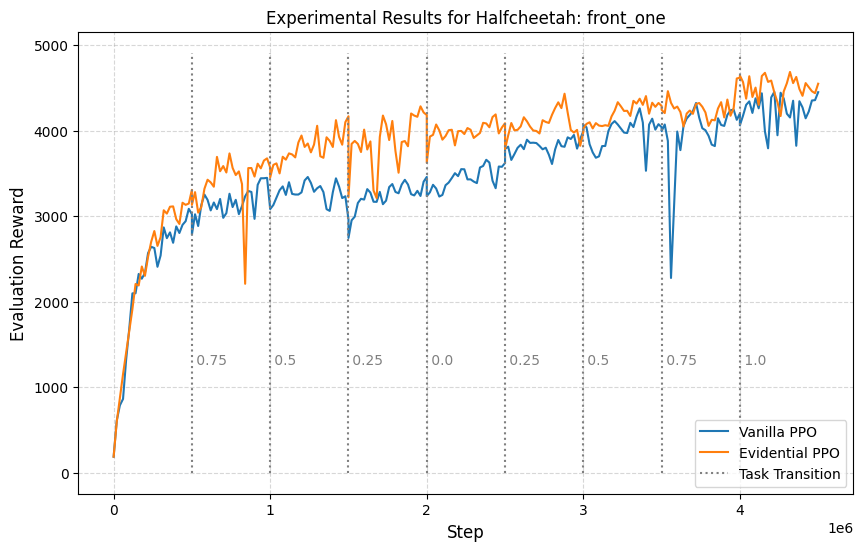

In [172]:
# @title Display results
import re
import matplotlib.pyplot as plt

eval_outputs_experiment = re.findall(r'N-steps:\s+(\d+)\s+Mean_Reward:\s+(\d+\.\d+)', result_output_experiment)
eval_outputs_experiment = np.array([[int(x[0]), float(x[1])] for x in eval_outputs_experiment])

eval_outputs = re.findall(r'N-steps:\s+(\d+)\s+Mean_Reward:\s+(\d+\.\d+)', result_output)
eval_outputs = np.array([[int(x[0]), float(x[1])] for x in eval_outputs])

task_breakpoints = re.findall(r'(\d+)\s+(?:Mean_)Reward:\s+\d+\.\d+ [a-zA-Z\s]*? task\s+\d:\s+(\d+\.\d+)', result_output)
task_breakpoints = np.array([[int(x[0]), float(x[1])] for x in task_breakpoints])

plt.figure(figsize=(10, 6))
plt.plot(eval_outputs[:,0], eval_outputs[:,1], label='Vanilla PPO')
plt.plot(eval_outputs_experiment[:,0], eval_outputs_experiment[:,1], label='Evidential PPO')
y_max = plt.gca().get_ylim()[1]
plt.vlines(x=task_breakpoints[:, 0], ymin=0, ymax=y_max, color='gray', linestyle=':', label='Task Transition')
for x, label in zip(task_breakpoints[:, 0], task_breakpoints[:, 1]):
    plt.text(x, y_max/4, f' {label}', verticalalignment='bottom', color='gray')

plt.title(f"Experimental Results for {environment.capitalize()}: {strategy}")
plt.xlabel('Step', fontsize=12)
plt.ylabel('Evaluation Reward', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(loc='lower right', frameon=True)
pass